# Drone Detection System Using Computer Vision

---

## Research Question

**How can drone detection in images or video frames using computer vision techniques help security, surveillance, airspace monitoring, and wildlife protection?**

---

## Expected Data Source
- **Primary Dataset**: [Roboflow Drone Detection Dataset](https://universe.roboflow.com/ahmedmohsen/drone-detection-new-peksv)
- **Local Dataset Path**: `/content/drive/MyDrive/Colab Notebooks/drone/drone-dataset.zip`

---

## Expected Techniques for Analysis

### 1. **Dataset Collection and Annotation**
- Image collection from various sources
- Proper labeling and annotation of drone objects
- Quality assurance and validation

### 2. **Data Preprocessing**
- Image resizing and normalization
- Data augmentation techniques
- Noise reduction and enhancement

### 3. **Detection Framework Selection**
- **YOLO (You Only Look Once)**: Real-time detection
- **Faster R-CNN**: High accuracy detection
- **Custom CNN**: Tailored architecture
- Trade-off analysis between efficiency and accuracy

### 4. **Model Configuration and Training**
- Neural network architecture design
- Hyperparameter optimization
- Training with appropriate loss functions

### 5. **Model Evaluation**
- Classification metrics (Precision, Recall, F1-score)
- Mean Average Precision (mAP)
- Confusion matrix analysis

### 6. **Deployment and Monitoring**
- Model deployment strategies
- Performance monitoring
- Retraining protocols

---

## Expected Results

The trained model should achieve:
- **High accuracy** in drone detection and localization
- **Strong performance metrics**: Precision, Recall, mAP
- **Real-time processing capability** for video frames
- **Robust detection** across various environmental conditions

---

## Importance of This Research

### Security and Safety Benefits
- **Civilian Protection**: Detecting potentially armed drones
- **Critical Infrastructure**: Safeguarding airports, government facilities
- **Privacy Protection**: Identifying unauthorized surveillance drones
- **Airspace Management**: Ensuring safe aviation operations

### Wildlife Conservation
- **Precision Detection**: Avoiding false positives that could harm wildlife
- **Conservation Monitoring**: Protecting endangered species from unauthorized surveillance
- **Habitat Preservation**: Minimizing disruption to natural environments

In [77]:
%%capture
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install tensorflow
%pip install sklearn
%pip install opencv-python
%pip install zipfile
%pip install scikit-image

In [78]:
import zipfile
import io
import tensorflow as tf
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter, defaultdict
import os
import sys
from scipy import stats as scipy_stats
from skimage import filters, segmentation, measure, feature
from skimage.feature import local_binary_pattern, hog
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Reshape, BatchNormalization, Dropout, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError

In [79]:
# Configuration and constants
zip_path = "data/drone-dataset-sample.zip"
train_base_folder = "drone-dataset-sample/train"
test_base_folder = "drone-dataset-sample/test"
valid_base_folder = "drone-dataset-sample/valid"
img_size = (224, 224)
MAX_BOXES = 10
class_names = ['AIRPLANE', 'DRONE', 'HELICOPTER', 'BIRD']
NUM_CLASSES = len(class_names)
EPOCHS = 20
BATCH_SIZE = 32
SMALL_BATCH_SIZE = 8

In [80]:
# Global declarations
# Initialize loss and metric functions
mse_loss = MeanSquaredError()
mae_metric = MeanAbsoluteError()
# Initialize variables
imbalance_ratio = 1.0
y_labels = y_train_cls
eda_results = {}

In [81]:
# prompt: load file from google drive

# from google.colab import drive
# drive.mount('/content/drive')

# After mounting, you can access files in your Google Drive
# If your file is in a specific folder within your Drive, e.g., 'MyFolder':
# with open('/content/drive/MyDrive/MyFolder/my_other_data.txt', 'r') as f:
#   content = f.read()
#   print(content)

# Load Images and class labels into memory

In [82]:
# Parsing Yolo Labels
def parse_yolo_label(txt):
    '''
    Parse YOLO label format to numpy array
    '''
    boxes = []
    for line in txt.strip().split("\n"):
        if line.strip():  # Skip empty lines
            parts = line.split()
            if len(parts) >= 5:
                cls, x, y, w, h = map(float, parts[:5])
                boxes.append([cls, x, y, w, h])
    return np.array(boxes, dtype=np.float32)

# Loading images and label files from .zip dataset
def load_image_and_label(zip_ref, img_path):
    '''
    Load image and label from zip file
    '''
    if img_path.endswith(".jpg") or img_path.endswith(".png"):
        label_path = img_path.replace("/images/", "/labels/").replace(".jpg", ".txt").replace(".png", ".txt")

        # Load and preprocess image
        try:
            with zip_ref.open(img_path) as img_file:
                image = Image.open(img_file).convert("RGB").resize(img_size)
                image_np = np.array(image) / 255.0
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

        # Load and parse label
        try:
            with zip_ref.open(label_path) as label_file:
                txt = label_file.read().decode("utf-8")
                if len(txt.strip()) == 0:
                    # For empty label files, infer class from filename/path
                    if "AIRPLANE" in img_path.upper():
                        labels = np.array([[0, 0.5, 0.5, 0.3, 0.3]], dtype=np.float32)
                    elif "BIRD" in img_path.upper():
                        labels = np.array([[3, 0.5, 0.5, 0.2, 0.2]], dtype=np.float32)
                    elif "DRONE" in img_path.upper():
                        labels = np.array([[1, 0.5, 0.5, 0.25, 0.25]], dtype=np.float32)
                    elif "HELICOPTER" in img_path.upper():
                        labels = np.array([[2, 0.5, 0.5, 0.4, 0.3]], dtype=np.float32)
                    else:
                        labels = np.zeros((0, 5), dtype=np.float32)
                else:
                    labels = parse_yolo_label(txt)
        except KeyError:
            # If label file doesn't exist, try to infer from image path
            if "AIRPLANE" in img_path.upper():
                labels = np.array([[0, 0.5, 0.5, 0.3, 0.3]], dtype=np.float32)
            elif "BIRD" in img_path.upper():
                labels = np.array([[3, 0.5, 0.5, 0.2, 0.2]], dtype=np.float32)
            elif "DRONE" in img_path.upper():
                labels = np.array([[1, 0.5, 0.5, 0.25, 0.25]], dtype=np.float32)
            elif "HELICOPTER" in img_path.upper():
                labels = np.array([[2, 0.5, 0.5, 0.4, 0.3]], dtype=np.float32)
            else:
                labels = np.zeros((0, 5), dtype=np.float32)

        return image_np.astype(np.float32), labels

# Load .zip dataset from underlying filesystem
def load_dataset(zip_path, base_folder):
    '''
    Load dataset from zip file
    '''
    X = []
    Y = []

    if not os.path.exists(zip_path):
        print(f"Error: Zip file {zip_path} not found!")
        return None, None

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        # Get all image paths
        image_paths = [f for f in zip_ref.namelist()
                      if f.startswith(f"{base_folder}/images/") and f.endswith((".jpg", ".png"))]

        print(f"Found {len(image_paths)} images in {base_folder}")

        for i, path in enumerate(image_paths):
            try:
                img, label = load_image_and_label(zip_ref, path)
                if img is not None and label is not None:
                    # Pad labels to fixed length
                    padded = np.zeros((MAX_BOXES, 5), dtype=np.float32)
                    if len(label) > 0:
                        padded[:min(len(label), MAX_BOXES)] = label[:MAX_BOXES]
                    X.append(img)
                    Y.append(padded)

                    if (i + 1) % 50 == 0:
                        print(f"Processed {i + 1}/{len(image_paths)} images")

            except Exception as e:
                print(f"Error processing {path}: {e}")
                continue

    if len(X) == 0:
        print(f"No valid images found in {base_folder}")
        return None, None

    X = np.array(X).astype(np.float32)
    Y = np.array(Y).astype(np.float32)

    # Validate loaded files
    if np.isnan(X).any():
        print("Warning: NaNs found in X, replacing with zeros")
        X = np.nan_to_num(X)
    if np.isnan(Y).any():
        print("Warning: NaNs found in Y, replacing with zeros")
        Y = np.nan_to_num(Y)

    print(f"Loaded {len(X)} images with shape {X.shape}")

    return X, Y

In [83]:
# Load Training Dataset
print("Loading training data...")
X_train, Y_train = load_dataset(zip_path, train_base_folder)

if X_train is None:
  print("Failed to load training data!")

Loading training data...
Found 2000 images in drone-dataset-sample/train
Processed 50/2000 images
Processed 100/2000 images
Processed 150/2000 images
Processed 200/2000 images
Processed 250/2000 images
Processed 300/2000 images
Processed 350/2000 images
Processed 400/2000 images
Processed 450/2000 images
Processed 500/2000 images
Processed 550/2000 images
Processed 600/2000 images
Processed 650/2000 images
Processed 700/2000 images
Processed 750/2000 images
Processed 800/2000 images
Processed 850/2000 images
Processed 900/2000 images
Processed 950/2000 images
Processed 1000/2000 images
Processed 1050/2000 images
Processed 1100/2000 images
Processed 1150/2000 images
Processed 1200/2000 images
Processed 1250/2000 images
Processed 1300/2000 images
Processed 1350/2000 images
Processed 1400/2000 images
Processed 1450/2000 images
Processed 1500/2000 images
Processed 1550/2000 images
Processed 1600/2000 images
Processed 1650/2000 images
Processed 1700/2000 images
Processed 1750/2000 images
Pr

In [84]:
print("Loading validation data...")
X_val, Y_val = load_dataset(zip_path, valid_base_folder)

Loading validation data...
Found 400 images in drone-dataset-sample/valid
Processed 50/400 images
Processed 100/400 images
Processed 150/400 images
Processed 200/400 images
Processed 250/400 images
Processed 300/400 images
Processed 350/400 images
Processed 400/400 images
Loaded 400 images with shape (400, 224, 224, 3)


In [85]:
print("Loading test data...")
X_test, Y_test = load_dataset(zip_path, test_base_folder)

Loading test data...
Found 400 images in drone-dataset-sample/test
Processed 50/400 images
Processed 100/400 images
Processed 150/400 images
Processed 200/400 images
Processed 250/400 images
Processed 300/400 images
Processed 350/400 images
Processed 400/400 images
Loaded 400 images with shape (400, 224, 224, 3)


# Data Preparation

## Converts object detection data into image classification data

In [86]:
# Converts object detection data into image classification data by extracting a single class label per image
# (specifically, the class of the first detected object in each image).
def create_classification_data(X, Y):
    '''
    Convert detection data to classification data by taking the first (most confident) class
    '''
    classification_labels = []
    valid_images = []

    for i in range(len(X)):
        # Find the first non-zero box
        valid_boxes = Y[i][~np.all(Y[i] == 0, axis=1)]

        if len(valid_boxes) > 0:
            # Use the first valid box's class
            class_id = int(valid_boxes[0, 0])
            if 0 <= class_id < NUM_CLASSES:
                classification_labels.append(class_id)
                valid_images.append(X[i])

    return np.array(valid_images), np.array(classification_labels)

In [87]:
# Create classification data
print("\nPreparing classification data...")
X_train_cls, y_train_cls = create_classification_data(X_train, Y_train)

if len(X_train_cls) == 0:
    print("No valid classification data found!")

X_val_cls, y_val_cls = None, None
X_test_cls, y_test_cls = None, None

if X_val is not None:
    X_val_cls, y_val_cls = create_classification_data(X_val, Y_val)
if X_test is not None:
    X_test_cls, y_test_cls = create_classification_data(X_test, Y_test)

print(f"Classification data - Train: {len(X_train_cls)}, Val: {len(X_val_cls) if X_val_cls is not None else 0}, Test: {len(X_test_cls) if X_test_cls is not None else 0}")



Preparing classification data...
Classification data - Train: 2000, Val: 400, Test: 400


# Exploratory Data Analysis

## EDA - Class Balance

In image processing for classification or detection tasks, a class imbalance check means examining whether some classes (labels) have significantly more images or annotations than others.

In [88]:
def analyze_class_balance(y_labels, title="Class Distribution"):
    '''
    Analyze and visualize class balance
    '''
    print("="*60)
    print(f"CLASS BALANCE ANALYSIS - {title}")
    print("="*60)

    # Count class occurrences
    class_counts = Counter(y_labels)

    # Calculate percentages
    total_samples = len(y_labels)
    class_percentages = {class_names[cls]: (count/total_samples)*100
                        for cls, count in class_counts.items()}

    # Print statistics
    print(f"Total samples: {total_samples}")
    print("\nClass distribution:")
    for cls, count in class_counts.items():
        percentage = (count/total_samples)*100
        print(f"  {class_names[cls]}: {count} samples ({percentage:.1f}%)")

    # Calculate imbalance ratio
    max_count = max(class_counts.values())
    min_count = min(class_counts.values())
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
    print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}")

    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar plot
    classes = [class_names[cls] for cls in class_counts.keys()]
    counts = list(class_counts.values())
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

    ax1.bar(classes, counts, color=colors[:len(classes)])
    ax1.set_title('Class Distribution (Counts)')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Samples')
    ax1.tick_params(axis='x', rotation=45)

    # Add count labels on bars
    for i, count in enumerate(counts):
        ax1.text(i, count + max(counts)*0.01, str(count), ha='center')

    # Pie chart
    ax2.pie(counts, labels=classes, autopct='%1.1f%%', colors=colors[:len(classes)])
    ax2.set_title('Class Distribution (Percentages)')

    plt.tight_layout()
    plt.show()

    return class_counts, imbalance_ratio

## EDA - Pixel Statistics for Images

Pixel statistics refer to summary statistics computed over the pixel values of images. They help us understand the distribution, intensity, and variation of pixel data.

Pixel statistics help understand:
* Decide whether to normalize or standardize
* Detect outliers or corruption
* Understand contrast and brightness levels
* Compare channels in RGB images

In [89]:
def compute_pixel_statistics(X, y_labels=None):
    '''
    Compute comprehensive pixel statistics for images
    '''
    print("="*60)
    print("PIXEL STATISTICS ANALYSIS")
    print("="*60)

    # Overall statistics
    print("Overall Image Statistics:")
    print(f"  Mean pixel value: {np.mean(X):.4f}")
    print(f"  Std pixel value: {np.std(X):.4f}")
    print(f"  Min pixel value: {np.min(X):.4f}")
    print(f"  Max pixel value: {np.max(X):.4f}")

    # Channel-wise statistics
    print("\nChannel-wise Statistics:")
    for i, channel in enumerate(['Red', 'Green', 'Blue']):
        channel_data = X[:, :, :, i]
        print(f"  {channel} channel:")
        print(f"    Mean: {np.mean(channel_data):.4f}")
        print(f"    Std: {np.std(channel_data):.4f}")
        print(f"    Min: {np.min(channel_data):.4f}")
        print(f"    Max: {np.max(channel_data):.4f}")

    # Class-wise statistics if labels provided
    if y_labels is not None:
        print("\nClass-wise Statistics:")
        for class_id in np.unique(y_labels):
            class_images = X[y_labels == class_id]
            if len(class_images) > 0:
                print(f"  {class_names[class_id]}:")
                print(f"    Mean: {np.mean(class_images):.4f}")
                print(f"    Std: {np.std(class_images):.4f}")
                print(f"    Brightness: {np.mean(class_images, axis=(1,2,3)).mean():.4f}")
                print(f"    Contrast: {np.std(class_images, axis=(1,2,3)).mean():.4f}")

    # Visualize pixel distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Overall pixel histogram
    axes[0, 0].hist(X.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_title('Overall Pixel Distribution')
    axes[0, 0].set_xlabel('Pixel Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)

    # Channel-wise histograms
    colors = ['red', 'green', 'blue']
    for i, (channel, color) in enumerate(zip(['Red', 'Green', 'Blue'], colors)):
        axes[0, 1].hist(X[:, :, :, i].flatten(), bins=50, alpha=0.5,
                       label=channel, color=color, edgecolor='black')
    axes[0, 1].set_title('Channel-wise Pixel Distribution')
    axes[0, 1].set_xlabel('Pixel Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Brightness distribution
    brightness = np.mean(X, axis=(1, 2, 3))
    axes[1, 0].hist(brightness, bins=30, alpha=0.7, color='gold', edgecolor='black')
    axes[1, 0].set_title('Image Brightness Distribution')
    axes[1, 0].set_xlabel('Mean Brightness')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)

    # Contrast distribution
    contrast = np.std(X, axis=(1, 2, 3))
    axes[1, 1].hist(contrast, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].set_title('Image Contrast Distribution')
    axes[1, 1].set_xlabel('Standard Deviation')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'overall_stats': {'mean': np.mean(X), 'std': np.std(X), 'min': np.min(X), 'max': np.max(X)},
        'brightness': brightness,
        'contrast': contrast
    }

# EDA - Image Quality Metrics

Image quality metrics are quantitative measures used to assess how good or degraded an image is, often in relation to distortions like noise, blur, compression artifacts, or other imperfections introduced during acquisition, processing, or transmission. These metrics are essential for evaluating the performance of image processing algorithms, camera systems, and computer vision applications.  

We analyzed 6 types of image quality metrics:

* Brightness (mean luminance)
* Contrast (standard deviation)
* Sharpness (variance of Laplacian)
* Entropy (information content)
* Noise level (high frequency energy)
* Color richness (number of unique colors)

In [90]:
def analyze_image_quality_metrics(X, y_labels=None):
    '''
    Analyze various image quality metrics
    '''
    print("="*60)
    print("IMAGE QUALITY METRICS ANALYSIS")
    print("="*60)

    quality_metrics = {
        'brightness': [],
        'contrast': [],
        'sharpness': [],
        'entropy': [],
        'noise_level': [],
        'color_richness': []
    }

    # Analyze subset of images
    subset_size = min(200, len(X))
    subset_indices = np.random.choice(len(X), subset_size, replace=False)

    print(f"Analyzing {subset_size} images for quality metrics...")

    for i, idx in enumerate(subset_indices):
        img = X[idx]
        gray = rgb2gray(img)

        # 1. Brightness (mean luminance)
        brightness = np.mean(gray)
        quality_metrics['brightness'].append(brightness)

        # 2. Contrast (standard deviation)
        contrast = np.std(gray)
        quality_metrics['contrast'].append(contrast)

        # 3. Sharpness (variance of Laplacian)
        gray_uint8 = (gray * 255).astype(np.uint8)
        laplacian_var = cv2.Laplacian(gray_uint8, cv2.CV_64F).var()
        quality_metrics['sharpness'].append(laplacian_var)

        # 4. Entropy (information content)
        hist, _ = np.histogram(gray.flatten(), bins=256, density=True)
        # Remove zeros to avoid log(0) issues
        hist = hist[hist > 0]
        entropy = -np.sum(hist * np.log2(hist + 1e-10))
        quality_metrics['entropy'].append(entropy)

        # 5. Noise level (high frequency energy)
        # Apply high-pass filter and measure energy
        kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
        high_freq = cv2.filter2D(gray_uint8, -1, kernel)
        noise_level = np.std(high_freq)
        quality_metrics['noise_level'].append(noise_level)

        # 6. Color richness (number of unique colors)
        img_uint8 = (img * 255).astype(np.uint8)
        # Count unique colors (simplified)
        unique_colors = len(np.unique(img_uint8.reshape(-1, 3), axis=0))
        color_richness = unique_colors / (img_size[0] * img_size[1])  # Normalize
        quality_metrics['color_richness'].append(color_richness)

        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1}/{subset_size} images")

    # Convert to numpy arrays
    for key in quality_metrics:
        quality_metrics[key] = np.array(quality_metrics[key])

    # Print statistics
    print("\nQuality Metrics Statistics:")
    for metric, values in quality_metrics.items():
        print(f"  {metric.replace('_', ' ').title()}:")
        print(f"    Mean: {np.mean(values):.4f}")
        print(f"    Std: {np.std(values):.4f}")
        print(f"    Min: {np.min(values):.4f}")
        print(f"    Max: {np.max(values):.4f}")

    # Visualize quality metrics
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    y_subset = y_labels[subset_indices] if y_labels is not None else None
    colors = ['blue', 'red', 'green', 'orange']

    for i, (metric, values) in enumerate(quality_metrics.items()):
        ax = axes[i]

        if y_subset is not None:
            # Plot by class
            for class_id in np.unique(y_subset):
                mask = y_subset == class_id
                if np.sum(mask) > 0:
                    ax.hist(values[mask], bins=20, alpha=0.7,
                           color=colors[class_id], label=class_names[class_id])
            ax.legend()
        else:
            ax.hist(values, bins=20, alpha=0.7, color='skyblue')

        ax.set_title(f'{metric.replace("_", " ").title()} Distribution')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return quality_metrics

## EDA - Dimensionality Analysis

PCA (Principal Component Analysis) in image processing is a statistical technique used to reduce the dimensionality of image data while preserving as much important information as possible. In practice, this means transforming a potentially large set of correlated pixel values (features) into a smaller set of uncorrelated variables called principal components.

t-SNE (t-distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality reduction technique primarily used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D. Its main goal is to capture and preserve the local structure and relationships among data points, making it easier to identify patterns, clusters, or groupings that exist in the original high-dimensional space.

In [91]:
def perform_dimensionality_analysis(X, y_labels=None):
    '''
    Perform dimensionality reduction and visualization
    '''
    print("="*60)
    print("DIMENSIONALITY REDUCTION ANALYSIS")
    print("="*60)

    # Flatten images for analysis
    X_flat = X.reshape(X.shape[0], -1)

    # Subsample for computational efficiency
    n_samples = min(500, len(X_flat))
    indices = np.random.choice(len(X_flat), n_samples, replace=False)
    X_subset = X_flat[indices]
    y_subset = y_labels[indices] if y_labels is not None else None

    print(f"Analyzing {n_samples} samples...")

    # 1. PCA Analysis
    print("Performing PCA...")
    pca = PCA()
    X_pca = pca.fit_transform(X_subset)

    # Plot explained variance ratio
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Explained variance ratio
    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)

    axes[0, 0].plot(range(1, min(51, len(explained_var)+1)),
                   explained_var[:50], 'b-', linewidth=2)
    axes[0, 0].set_title('PCA: Explained Variance Ratio')
    axes[0, 0].set_xlabel('Principal Component')
    axes[0, 0].set_ylabel('Explained Variance Ratio')
    axes[0, 0].grid(True, alpha=0.3)

    # Cumulative explained variance
    axes[0, 1].plot(range(1, min(51, len(cumulative_var)+1)),
                   cumulative_var[:50], 'r-', linewidth=2)
    axes[0, 1].axhline(y=0.95, color='k', linestyle='--', alpha=0.7, label='95% Variance')
    axes[0, 1].set_title('PCA: Cumulative Explained Variance')
    axes[0, 1].set_xlabel('Number of Components')
    axes[0, 1].set_ylabel('Cumulative Explained Variance')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Find number of components for 95% variance
    n_components_95 = np.argmax(cumulative_var >= 0.95) + 1
    print(f"Components needed for 95% variance: {n_components_95}")

    # 2D PCA visualization
    if y_subset is not None:
        colors = ['blue', 'red', 'green', 'orange']
        for class_id in np.unique(y_subset):
            mask = y_subset == class_id
            axes[1, 0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                             c=colors[class_id], label=class_names[class_id], alpha=0.7)
        axes[1, 0].legend()
    else:
        axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)

    axes[1, 0].set_title('PCA: First Two Components')
    axes[1, 0].set_xlabel(f'PC1 ({explained_var[0]:.2%} variance)')
    axes[1, 0].set_ylabel(f'PC2 ({explained_var[1]:.2%} variance)')
    axes[1, 0].grid(True, alpha=0.3)

    # 2. t-SNE Analysis
    print("Performing t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_subset[:200])
    y_tsne = y_subset[:200] if y_subset is not None else None

    if y_tsne is not None:
        for class_id in np.unique(y_tsne):
            mask = y_tsne == class_id
            axes[1, 1].scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                             c=colors[class_id], label=class_names[class_id], alpha=0.7)
        axes[1, 1].legend()
    else:
        axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)

    axes[1, 1].set_title('t-SNE Visualization')
    axes[1, 1].set_xlabel('t-SNE 1')
    axes[1, 1].set_ylabel('t-SNE 2')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'pca': pca,
        'explained_variance_ratio': explained_var,
        'n_components_95': n_components_95,
        'X_pca': X_pca,
        'X_tsne': X_tsne
    }

## EDA - Analyzing Spatial Patterns

Spatial patterns is the process of examining how objects, events, or features are distributed across space to gain insights into underlying processes or relationships

In [92]:
def analyze_spatial_patterns(X, y_labels=None):
    '''
    Analyze spatial patterns and object distributions
    '''
    print("="*60)
    print("SPATIAL PATTERN ANALYSIS")
    print("="*60)

    # Analyze object positioning from bounding boxes if available
    spatial_stats = {
        'center_positions': [],
        'object_sizes': [],
        'aspect_ratios': [],
        'edge_distances': []
    }

    # For demonstration, create some analysis of spatial patterns
    print("Analyzing spatial distributions in images...")

    # Sample images for spatial analysis
    n_samples = min(50, len(X))
    sample_indices = np.random.choice(len(X), n_samples, replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Center region analysis
    center_intensities = []
    edge_intensities = []

    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)
        h, w = gray.shape

        # Define center and edge regions
        center_region = gray[h//4:3*h//4, w//4:3*w//4]
        edge_region = np.concatenate([
            gray[:h//4, :].flatten(),
            gray[3*h//4:, :].flatten(),
            gray[:, :w//4].flatten(),
            gray[:, 3*w//4:].flatten()
        ])

        center_intensities.append(np.mean(center_region))
        edge_intensities.append(np.mean(edge_region))

    axes[0, 0].scatter(center_intensities, edge_intensities, alpha=0.7)
    axes[0, 0].plot([0, 1], [0, 1], 'r--', alpha=0.5)
    axes[0, 0].set_xlabel('Center Intensity')
    axes[0, 0].set_ylabel('Edge Intensity')
    axes[0, 0].set_title('Center vs Edge Intensity')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Gradient magnitude analysis
    gradient_stats = []
    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)

        # Calculate gradients
        grad_x = np.gradient(gray, axis=1)
        grad_y = np.gradient(gray, axis=0)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

        gradient_stats.append(np.mean(gradient_magnitude))

    axes[0, 1].hist(gradient_stats, bins=15, alpha=0.7, color='green')
    axes[0, 1].set_xlabel('Mean Gradient Magnitude')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Gradient Magnitude Distribution')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Corner detection analysis
    corner_counts = []
    for idx in sample_indices[:20]:  # Limit for computational efficiency
        img = X[idx]
        gray = rgb2gray(img)
        gray_uint8 = (gray * 255).astype(np.uint8)

        # Harris corner detection
        corners = cv2.cornerHarris(gray_uint8, blockSize=2, ksize=3, k=0.04)
        corner_count = np.sum(corners > 0.01 * corners.max())
        corner_counts.append(corner_count)

    axes[0, 2].hist(corner_counts, bins=10, alpha=0.7, color='orange')
    axes[0, 2].set_xlabel('Number of Corners')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Corner Detection Analysis')
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Symmetry analysis
    symmetry_scores = []
    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)

        # Vertical symmetry
        left_half = gray[:, :gray.shape[1]//2]
        right_half = np.fliplr(gray[:, gray.shape[1]//2:])

        # Ensure same size for symmetry comparison
        min_width = min(left_half.shape[1], right_half.shape[1])
        min_height = min(left_half.shape[0], right_half.shape[0])
        left_half = left_half[:min_height, :min_width]
        right_half = right_half[:min_height, :min_width]

        symmetry_score = 1 - np.mean(np.abs(left_half - right_half))
        symmetry_scores.append(symmetry_score)

    axes[1, 0].hist(symmetry_scores, bins=15, alpha=0.7, color='purple')
    axes[1, 0].set_xlabel('Symmetry Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Vertical Symmetry Analysis')
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Frequency domain analysis
    frequency_energies = []
    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)

        # FFT analysis
        fft = np.fft.fft2(gray)
        fft_shift = np.fft.fftshift(fft)
        magnitude_spectrum = np.log(np.abs(fft_shift) + 1)

        # High frequency energy
        h, w = magnitude_spectrum.shape
        center_h, center_w = h//2, w//2
        high_freq_region = magnitude_spectrum.copy()
        high_freq_region[center_h-h//8:center_h+h//8, center_w-w//8:center_w+w//8] = 0

        high_freq_energy = np.sum(high_freq_region)
        frequency_energies.append(high_freq_energy)

    axes[1, 1].hist(frequency_energies, bins=15, alpha=0.7, color='red')
    axes[1, 1].set_xlabel('High Frequency Energy')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Frequency Domain Analysis')
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Texture complexity
    texture_complexity = []
    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)

        # Calculate local variance as texture measure using a simple approach
        kernel_size = 5
        h, w = gray.shape
        local_vars = []

        for i in range(0, h-kernel_size+1, kernel_size):
            for j in range(0, w-kernel_size+1, kernel_size):
                patch = gray[i:i+kernel_size, j:j+kernel_size]
                local_vars.append(np.var(patch))

        complexity = np.mean(local_vars) if local_vars else 0
        texture_complexity.append(complexity)

    axes[1, 2].hist(texture_complexity, bins=15, alpha=0.7, color='brown')
    axes[1, 2].set_xlabel('Texture Complexity')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title('Texture Complexity Analysis')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'center_intensities': center_intensities,
        'edge_intensities': edge_intensities,
        'gradient_stats': gradient_stats,
        'corner_counts': corner_counts,
        'symmetry_scores': symmetry_scores,
        'frequency_energies': frequency_energies,
        'texture_complexity': texture_complexity
    }

In [93]:
def eda_report_overview(X, Y):
    '''
    Generate a EDA report
    '''
    print("="*80)
    print("EXPLORATORY DATA ANALYSIS REPORT")
    print("="*80)

    # Dataset Overview
    print(f"\nDATASET OVERVIEW:")
    print(f"  Total samples: {len(X)}")
    print(f"  Image shape: {X.shape[1:]}")
    print(f"  Label shape: {Y.shape[1:]}")
    print(f"  Data type: {X.dtype}")
    print(f"  Memory usage: {X.nbytes / (1024**2):.2f} MB")
    return X, Y

X, Y = eda_report_overview(X_train_cls, Y_train)

EXPLORATORY DATA ANALYSIS REPORT

DATASET OVERVIEW:
  Total samples: 2000
  Image shape: (224, 224, 3)
  Label shape: (10, 5)
  Data type: float32
  Memory usage: 1148.44 MB


CLASS BALANCE ANALYSIS - Training Set
Total samples: 2000

Class distribution:
  BIRD: 365 samples (18.2%)
  AIRPLANE: 416 samples (20.8%)
  DRONE: 802 samples (40.1%)
  HELICOPTER: 417 samples (20.8%)

Imbalance ratio (max/min): 2.20


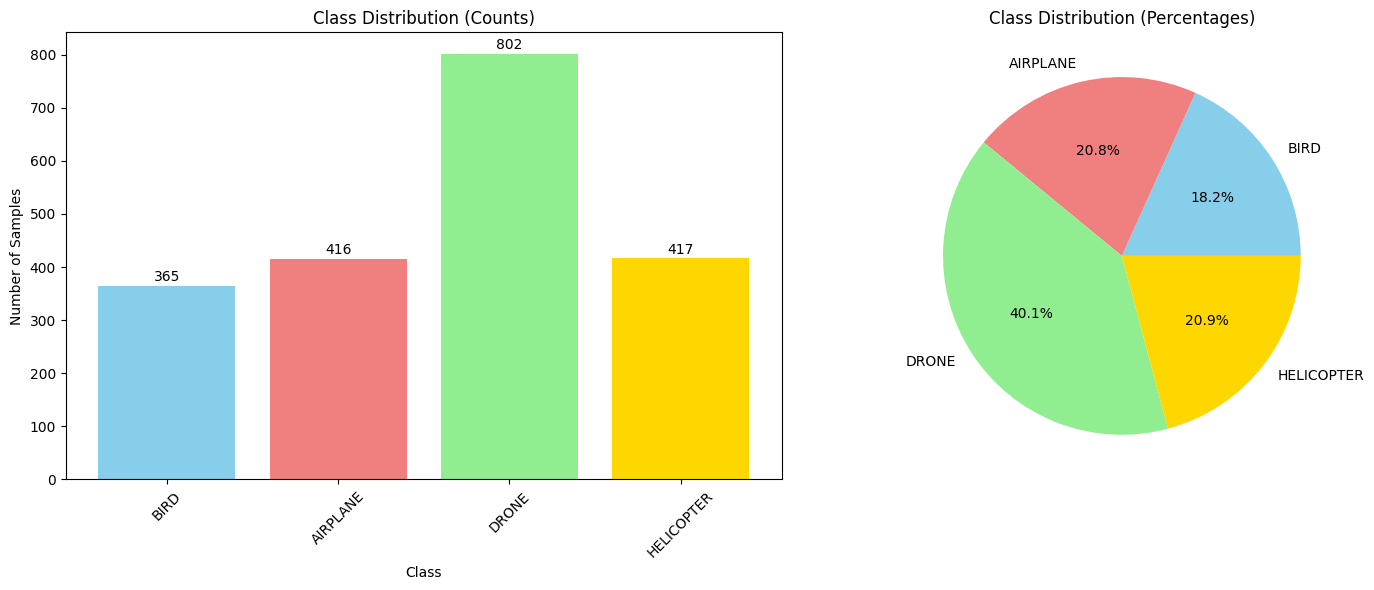

In [94]:
# Class Balance Analysis
if y_labels is not None:
  class_counts, imbalance_ratio = analyze_class_balance(y_labels, "Training Set")
  eda_results['class_balance'] = {'counts': class_counts, 'imbalance_ratio': imbalance_ratio}

PIXEL STATISTICS ANALYSIS
Overall Image Statistics:
  Mean pixel value: 0.5224
  Std pixel value: 0.1708
  Min pixel value: 0.0000
  Max pixel value: 1.0000

Channel-wise Statistics:
  Red channel:
    Mean: 0.4159
    Std: 0.1259
    Min: 0.0000
    Max: 1.0000
  Green channel:
    Mean: 0.5130
    Std: 0.1271
    Min: 0.0000
    Max: 1.0000
  Blue channel:
    Mean: 0.6382
    Std: 0.1752
    Min: 0.0000
    Max: 1.0000

Class-wise Statistics:
  AIRPLANE:
    Mean: 0.5306
    Std: 0.1536
    Brightness: 0.5306
    Contrast: 0.1409
  DRONE:
    Mean: 0.5169
    Std: 0.1892
    Brightness: 0.5169
    Contrast: 0.1824
  HELICOPTER:
    Mean: 0.5301
    Std: 0.1422
    Brightness: 0.5301
    Contrast: 0.1169
  BIRD:
    Mean: 0.5162
    Std: 0.1760
    Brightness: 0.5162
    Contrast: 0.1692


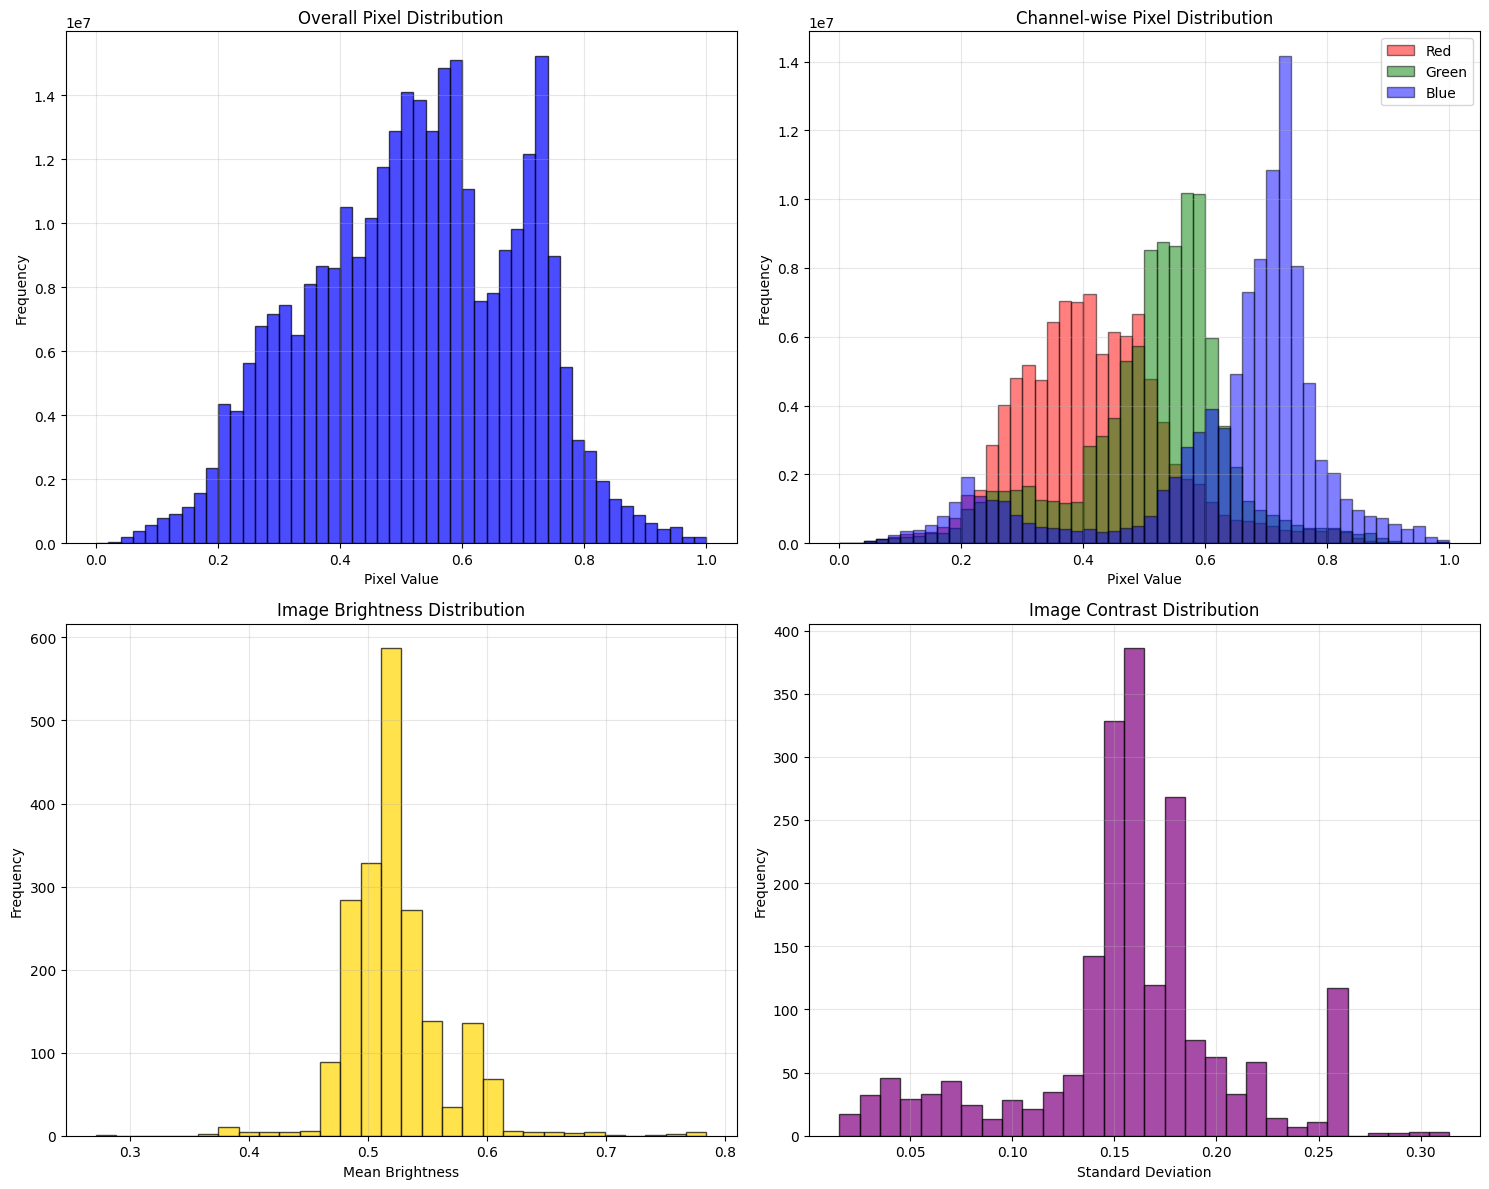

In [95]:
# Pixel Statistics
pixel_stats = compute_pixel_statistics(X, y_labels)
eda_results['pixel_statistics'] = pixel_stats

IMAGE QUALITY METRICS ANALYSIS
Analyzing 200 images for quality metrics...
Processed 50/200 images
Processed 100/200 images
Processed 150/200 images
Processed 200/200 images

Quality Metrics Statistics:
  Brightness:
    Mean: 0.4975
    Std: 0.0466
    Min: 0.3356
    Max: 0.6526
  Contrast:
    Mean: 0.1006
    Std: 0.0574
    Min: 0.0156
    Max: 0.3120
  Sharpness:
    Mean: 92.4248
    Std: 100.6531
    Min: 1.1917
    Max: 714.5797
  Entropy:
    Mean: -1564.8546
    Std: 1883.6937
    Min: -11954.5280
    Max: -199.7946
  Noise Level:
    Mean: 14.0319
    Std: 7.4729
    Min: 1.9367
    Max: 39.8792
  Color Richness:
    Mean: 0.1347
    Std: 0.0995
    Min: 0.0057
    Max: 0.4952


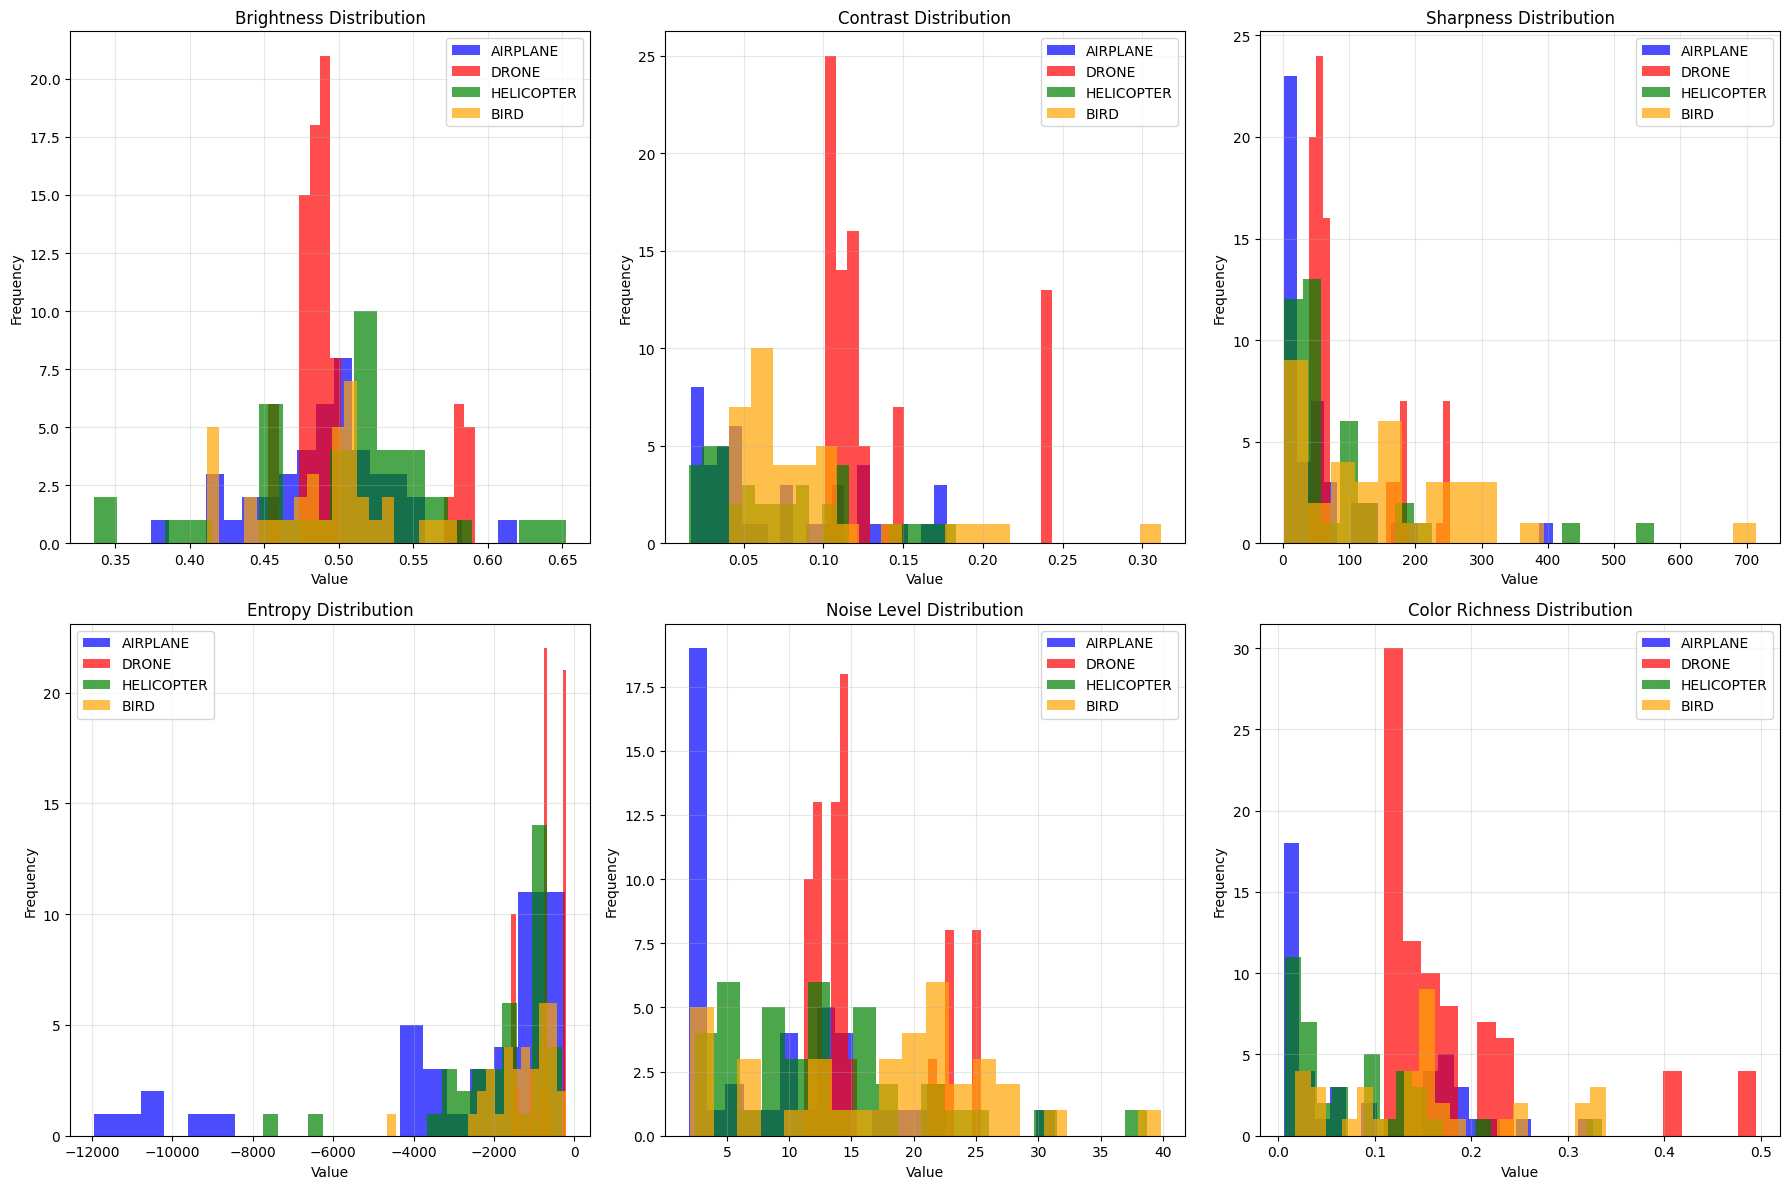

In [96]:
# Image Quality Metrics
quality_metrics = analyze_image_quality_metrics(X, y_labels)
eda_results['quality_metrics'] = quality_metrics

DIMENSIONALITY REDUCTION ANALYSIS
Analyzing 500 samples...
Performing PCA...
Components needed for 95% variance: 26
Performing t-SNE...


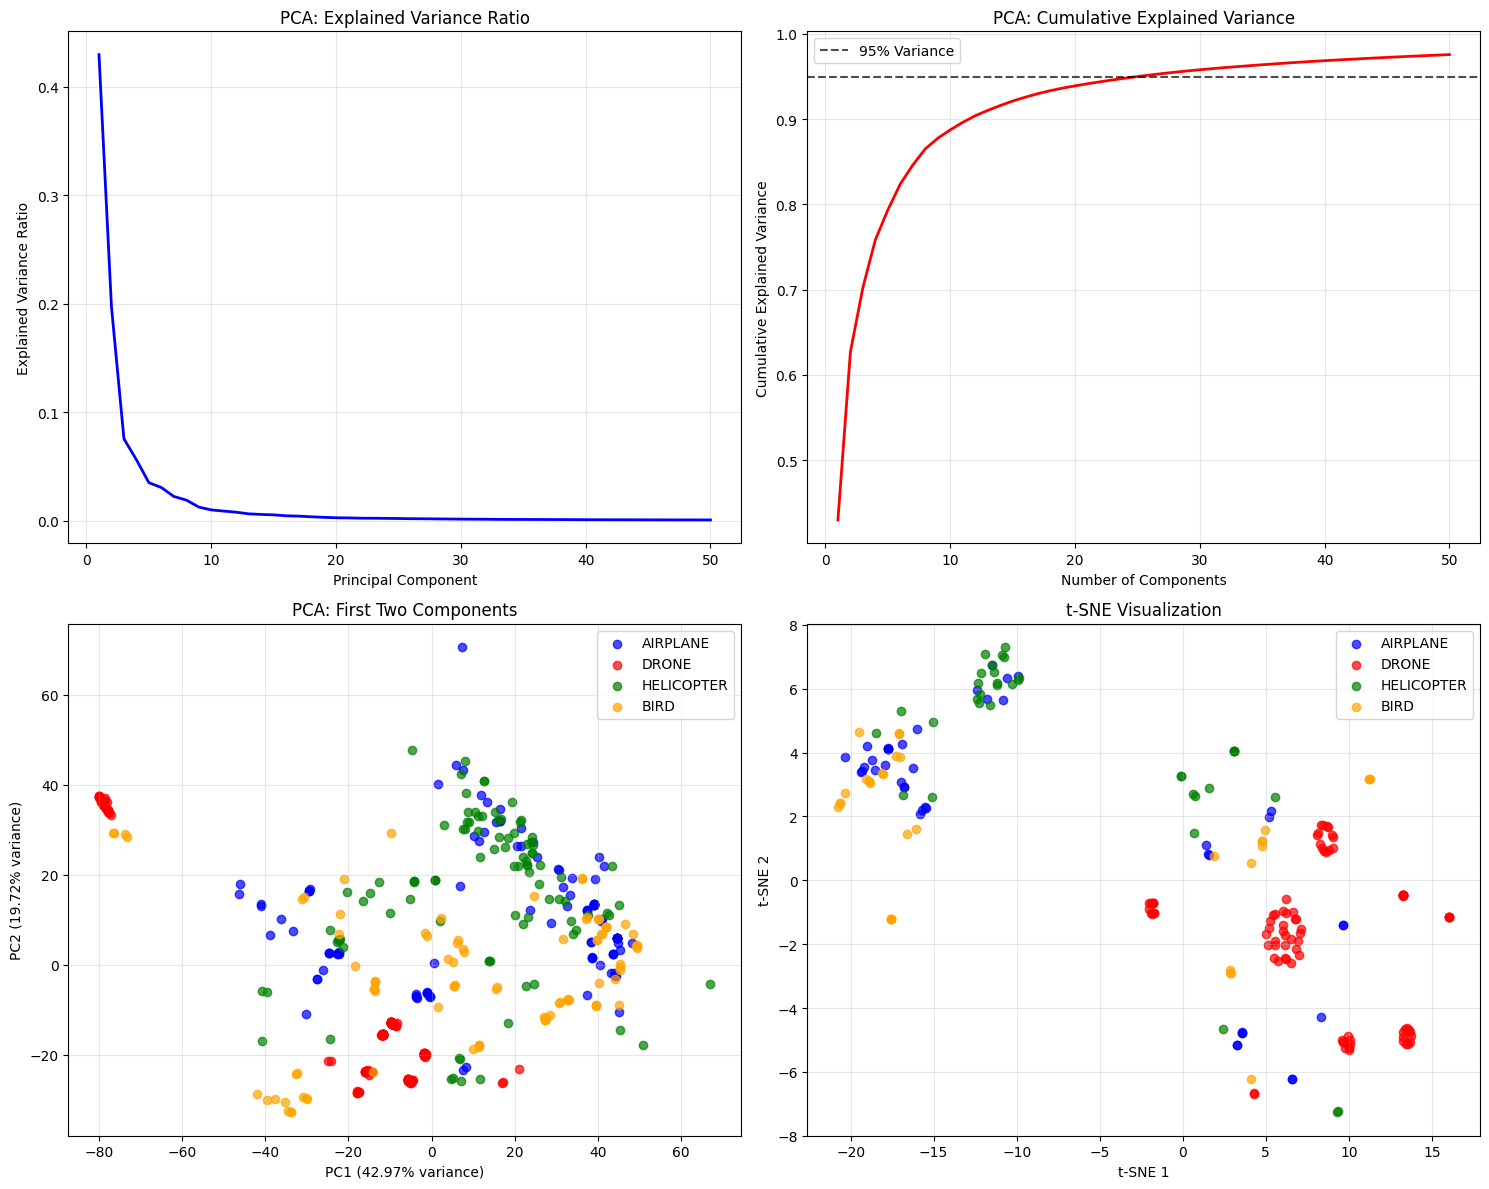

In [97]:
# Dimensionality Analysis
dim_analysis = perform_dimensionality_analysis(X, y_labels)
eda_results['dimensionality'] = dim_analysis

SPATIAL PATTERN ANALYSIS
Analyzing spatial distributions in images...


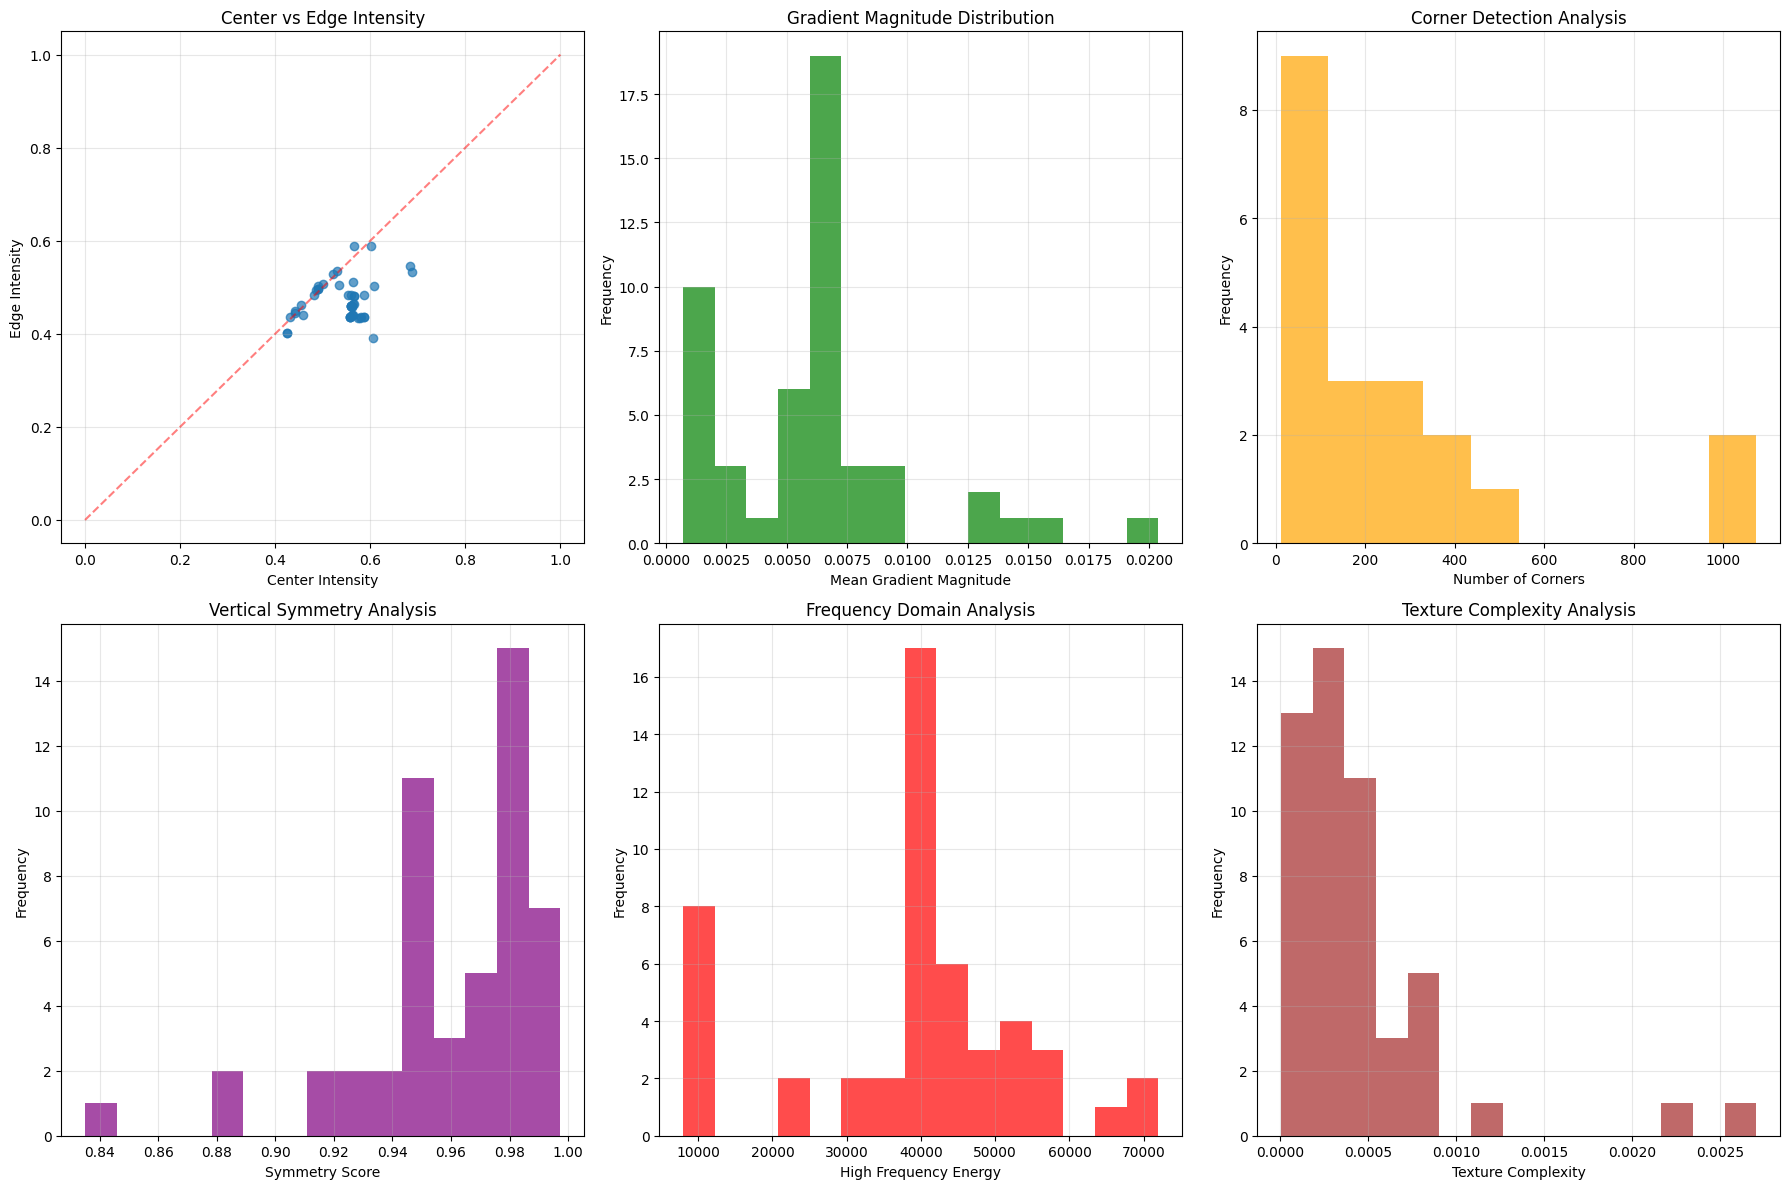

In [98]:
# Spatial Pattern Analysis
spatial_patterns = analyze_spatial_patterns(X, y_labels)
eda_results['spatial_patterns'] = spatial_patterns

In [99]:
def eda_report(X):
    '''
    Generate a EDA report based recommendation
    '''
    # 7. Generate recommendations
    print("\n" + "="*60)
    print("RECOMMENDATIONS BASED ON EDA")
    print("="*60)

    recommendations = []

    # Class imbalance recommendations
    if y_labels is not None and imbalance_ratio > 2:
        recommendations.append(f"• High class imbalance detected (ratio: {imbalance_ratio:.2f}). Consider data augmentation or class weighting.")

    # Brightness recommendations
    brightness_std = np.std(pixel_stats['brightness'])
    if brightness_std > 0.2:
        recommendations.append("• High brightness variation detected. Consider brightness normalization.")

    # Contrast recommendations
    contrast_mean = np.mean(pixel_stats['contrast'])
    if contrast_mean < 0.1:
        recommendations.append("• Low contrast images detected. Consider contrast enhancement techniques.")

    # Sharpness recommendations
    sharpness_values = quality_metrics['sharpness']
    if np.mean(sharpness_values) < 100:
        recommendations.append("• Low sharpness detected in some images. Consider sharpening filters.")

    # Noise recommendations
    noise_values = quality_metrics['noise_level']
    if np.mean(noise_values) > 50:
        recommendations.append("• High noise levels detected. Consider denoising techniques.")

    # Dimensionality recommendations
    if dim_analysis['n_components_95'] < X.shape[1] * X.shape[2] * X.shape[3] * 0.1:
        recommendations.append("• Low intrinsic dimensionality detected. PCA preprocessing might be beneficial.")

    if len(recommendations) == 0:
        recommendations.append("• Dataset appears to be of good quality. Standard preprocessing should be sufficient.")

    for rec in recommendations:
        print(rec)

    eda_results['recommendations'] = recommendations

    return eda_results

In [100]:
eda_results = eda_report(X_train_cls)


RECOMMENDATIONS BASED ON EDA
• High class imbalance detected (ratio: 2.20). Consider data augmentation or class weighting.
• Low sharpness detected in some images. Consider sharpening filters.
• Low intrinsic dimensionality detected. PCA preprocessing might be beneficial.


# Image Preprocessing

## Denoising Images

Denoising is the process of removing noise (unwanted random variations or artifacts) from data — especially images, audio, or signals — to improve quality and clarity.

In image denoising, the goal is to:
* Preserve important features like edges and textures
* Eliminate unwanted variations like grain, blur, or compression artifacts

In [101]:
def apply_denoising_techniques(X, y_labels=None):
    '''
    Apply various denoising and preprocessing techniques
    '''
    print("="*60)
    print("DENOISING AND PREPROCESSING")
    print("="*60)

    # Select a sample image for demonstration
    sample_idx = 0
    sample_img = X[sample_idx]

    # Convert to uint8 for OpenCV operations
    sample_img_uint8 = (sample_img * 255).astype(np.uint8)

    # Apply various denoising techniques
    techniques = {}

    # 1. Gaussian Blur
    gaussian_blur = cv2.GaussianBlur(sample_img_uint8, (5, 5), 0)
    techniques['Gaussian Blur'] = gaussian_blur / 255.0

    # 2. Median Filter
    median_filter = cv2.medianBlur(sample_img_uint8, 5)
    techniques['Median Filter'] = median_filter / 255.0

    # 3. Bilateral Filter
    bilateral_filter = cv2.bilateralFilter(sample_img_uint8, 9, 75, 75)
    techniques['Bilateral Filter'] = bilateral_filter / 255.0

    # 4. Non-local Means Denoising
    nlm_denoised = cv2.fastNlMeansDenoisingColored(sample_img_uint8, None, 10, 10, 7, 21)
    techniques['NLM Denoising'] = nlm_denoised / 255.0

    # 5. Grayscale conversion
    gray_img = cv2.cvtColor(sample_img_uint8, cv2.COLOR_RGB2GRAY)
    techniques['Grayscale'] = gray_img / 255.0

    # 6. Edge Enhancement (Unsharp Masking)
    gaussian = cv2.GaussianBlur(sample_img_uint8, (0, 0), 2.0)
    unsharp_mask = cv2.addWeighted(sample_img_uint8, 1.5, gaussian, -0.5, 0)
    techniques['Edge Enhanced'] = unsharp_mask / 255.0

    # 7. Histogram Equalization
    img_yuv = cv2.cvtColor(sample_img_uint8, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    hist_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    techniques['Histogram Equalized'] = hist_eq / 255.0

    # 8. CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    img_lab = cv2.cvtColor(sample_img_uint8, cv2.COLOR_RGB2LAB)
    img_lab[:, :, 0] = clahe.apply(img_lab[:, :, 0])
    clahe_img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    techniques['CLAHE'] = clahe_img / 255.0

    # Visualize all techniques
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.flatten()

    # Original image
    axes[0].imshow(sample_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Denoised images
    for i, (name, img) in enumerate(techniques.items(), 1):
        if len(img.shape) == 3:
            axes[i].imshow(img)
        else:
            axes[i].imshow(img, cmap='gray')
        axes[i].set_title(name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    # Apply denoising to entire dataset
    print("\nApplying Gaussian blur to entire dataset...")
    X_denoised = np.zeros_like(X)
    for i in range(len(X)):
        img_uint8 = (X[i] * 255).astype(np.uint8)
        blurred = cv2.GaussianBlur(img_uint8, (3, 3), 0)
        X_denoised[i] = blurred / 255.0

        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{len(X)} images")

    return X_denoised, techniques


Applying denoising techniques...
DENOISING AND PREPROCESSING


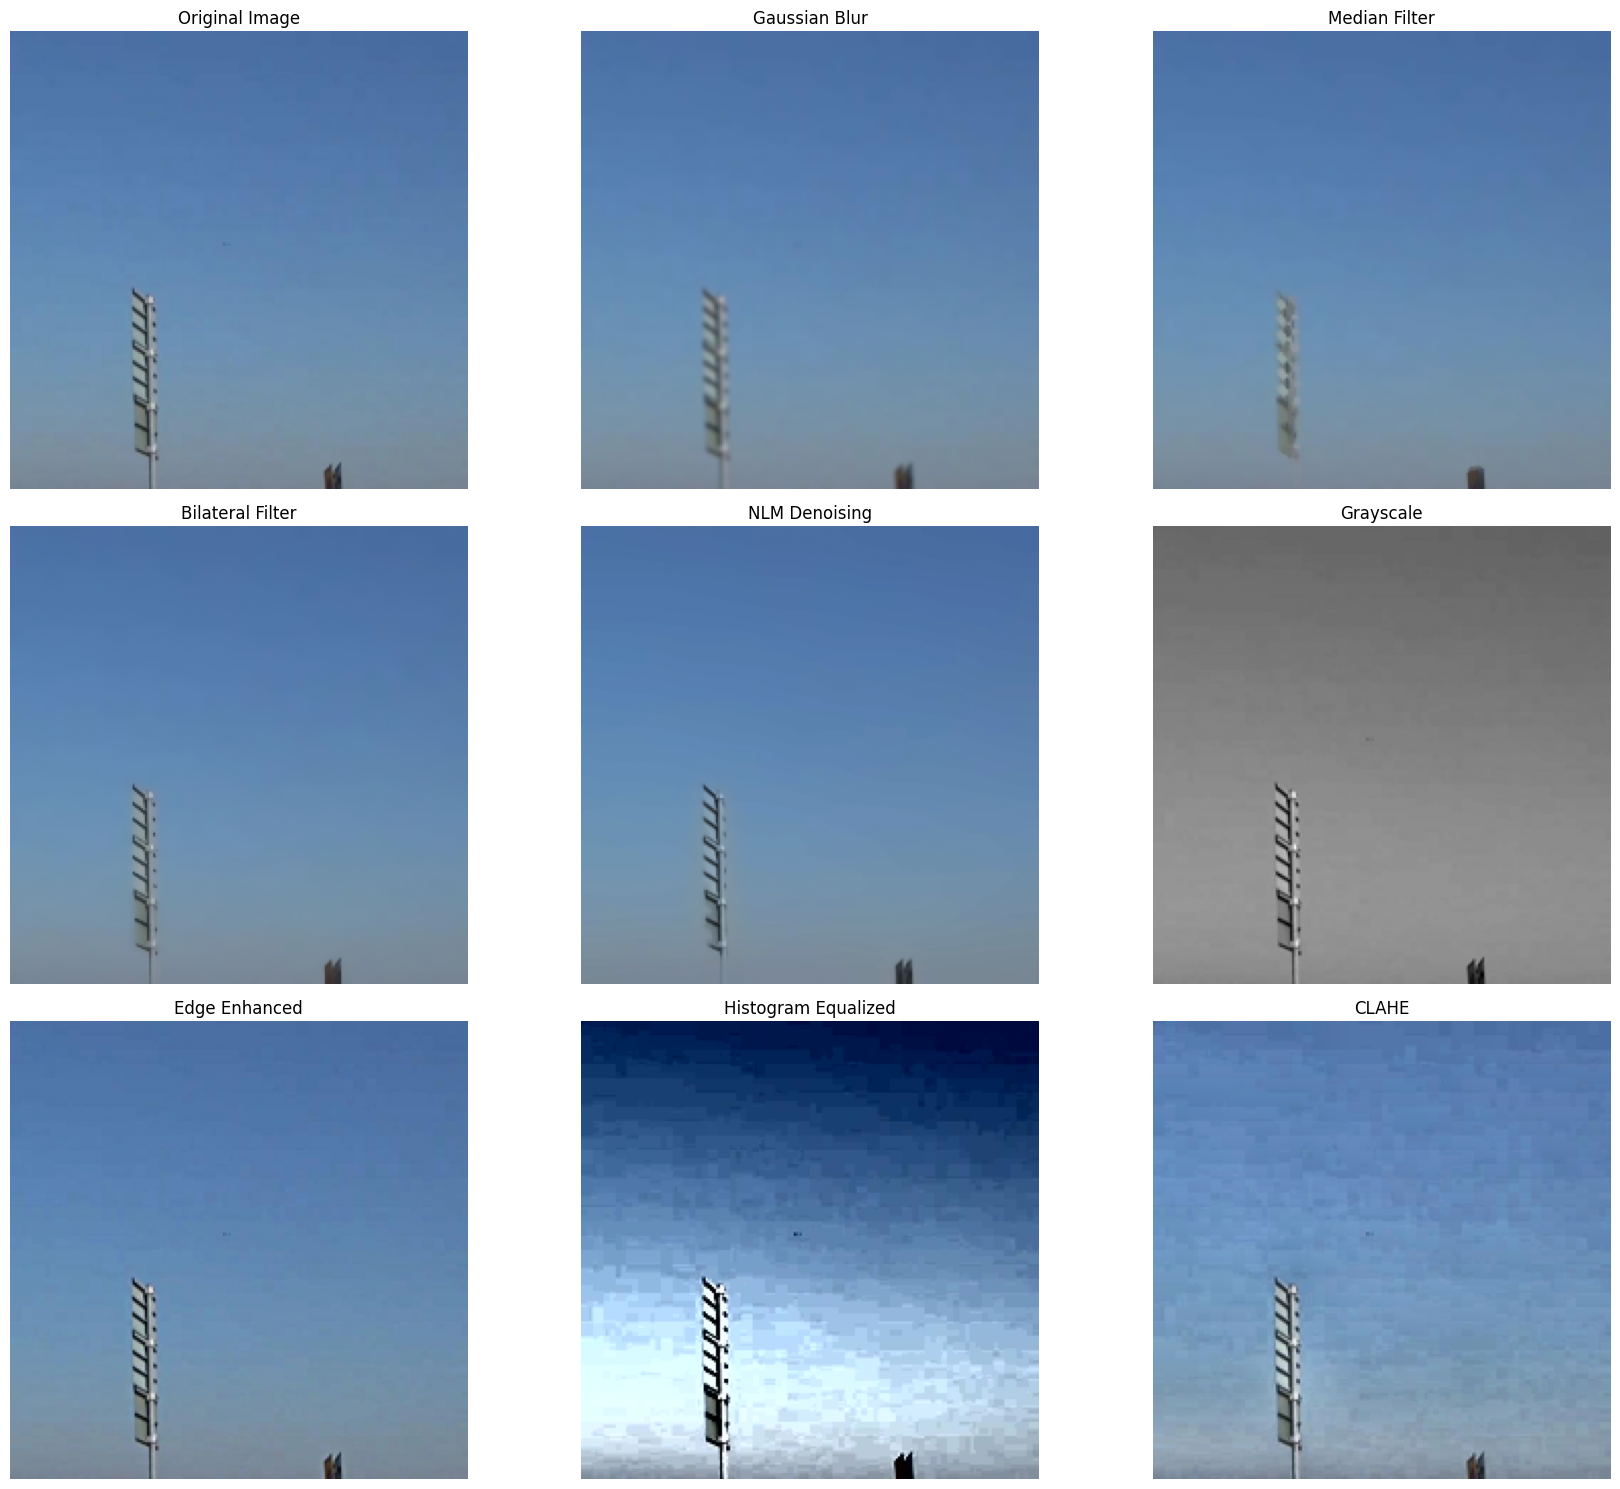


Applying Gaussian blur to entire dataset...
Processed 100/2000 images
Processed 200/2000 images
Processed 300/2000 images
Processed 400/2000 images
Processed 500/2000 images
Processed 600/2000 images
Processed 700/2000 images
Processed 800/2000 images
Processed 900/2000 images
Processed 1000/2000 images
Processed 1100/2000 images
Processed 1200/2000 images
Processed 1300/2000 images
Processed 1400/2000 images
Processed 1500/2000 images
Processed 1600/2000 images
Processed 1700/2000 images
Processed 1800/2000 images
Processed 1900/2000 images
Processed 2000/2000 images


In [102]:
# Apply denoising techniques
print("\nApplying denoising techniques...")
X_train_denoised, denoising_techniques = apply_denoising_techniques(X_train_cls, y_train_cls)

# Feature Extractions

Image Feature extraction involves transforming raw data into meaningful information that machine learning models can learn from.

For images, this often means extracting things like:
 * Edges
 * Textures
 * Shapes
 * Keypoints

## Sobel Filter Edge Detection

The Sobel filter is a edge detection operator used in image processing and computer vision to find edges based on gradients.

It highlights regions of the image with high spatial frequency — i.e., where the intensity (brightness) changes sharply. These are often boundaries or outlines of objects in the image.

In [103]:
def sobel_filter_edge_detection(image):
    '''
    Safe Sobel filter with fallback
    '''
    try:
        return filters.sobel(image)
    except:
        # Fallback: manual Sobel implementation
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

        # Apply convolution (simplified)
        grad_x = cv2.filter2D(image.astype(np.float32), -1, sobel_x)
        grad_y = cv2.filter2D(image.astype(np.float32), -1, sobel_y)

        return np.sqrt(grad_x**2 + grad_y**2)

In [104]:
def visualize_feature_distributions(features_dict, y_labels=None):
    '''
    Visualize distribution of extracted features
    '''
    print("Visualizing feature distributions...")

    n_features = len(features_dict)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    colors = ['blue', 'red', 'green', 'orange']

    for i, (feature_name, features) in enumerate(features_dict.items()):
        if i >= 6:  # Limit to 6 plots
            break

        ax = axes[i]

        # For high-dimensional features, show PCA
        if features.shape[1] > 50:
            # Apply PCA to reduce dimensionality
            pca = PCA(n_components=2)
            features_pca = pca.fit_transform(features)

            if y_labels is not None:
                # Plot by class
                for class_id in np.unique(y_labels):
                    mask = y_labels == class_id
                    ax.scatter(features_pca[mask, 0], features_pca[mask, 1],
                             c=colors[class_id], label=class_names[class_id], alpha=0.7)
                ax.legend()
                ax.set_title(f'{feature_name} Features (PCA)')
            else:
                ax.scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.7)
                ax.set_title(f'{feature_name} Features (PCA)')

            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')

        else:
            # For low-dimensional features, show histogram
            if y_labels is not None:
                # Plot histogram by class
                for class_id in np.unique(y_labels):
                    mask = y_labels == class_id
                    if np.sum(mask) > 0:
                        ax.hist(features[mask, 0], bins=20, alpha=0.7,
                               color=colors[class_id], label=class_names[class_id])
                ax.legend()
            else:
                ax.hist(features[:, 0], bins=20, alpha=0.7)

            ax.set_title(f'{feature_name} Features (First Dimension)')
            ax.set_xlabel('Feature Value')
            ax.set_ylabel('Frequency')

        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [105]:
def extract_traditional_features(X, y_labels=None):
    '''
    Extract traditional computer vision features
    '''
    print("="*60)
    print("TRADITIONAL FEATURE EXTRACTION")
    print("="*60)

    features_dict = {}

    # Select subset for feature extraction (to avoid memory issues)
    subset_size = min(100, len(X))
    subset_indices = np.random.choice(len(X), subset_size, replace=False)
    X_subset = X[subset_indices]
    y_subset = y_labels[subset_indices] if y_labels is not None else None

    print(f"Extracting features from {subset_size} images...")

    # 1. HOG (Histogram of Oriented Gradients) Features
    print("Extracting HOG features...")
    hog_features = []
    for i, img in enumerate(X_subset):
        gray = rgb2gray(img)
        hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=False)
        hog_features.append(hog_feat)

    hog_features = np.array(hog_features)
    features_dict['HOG'] = hog_features
    print(f"HOG features shape: {hog_features.shape}")

    # 2. LBP (Local Binary Pattern) Features
    print("Extracting LBP features...")
    lbp_features = []
    for i, img in enumerate(X_subset):
        gray = rgb2gray(img)
        gray_uint8 = img_as_ubyte(gray)
        lbp = local_binary_pattern(gray_uint8, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=10, density=True)
        lbp_features.append(hist)

    lbp_features = np.array(lbp_features)
    features_dict['LBP'] = lbp_features
    print(f"LBP features shape: {lbp_features.shape}")

    # 3. Color Histogram Features
    print("Extracting color histogram features...")
    color_features = []
    for i, img in enumerate(X_subset):
        # RGB histograms
        hist_r = np.histogram(img[:, :, 0], bins=32, range=(0, 1))[0]
        hist_g = np.histogram(img[:, :, 1], bins=32, range=(0, 1))[0]
        hist_b = np.histogram(img[:, :, 2], bins=32, range=(0, 1))[0]

        # Normalize histograms
        hist_r = hist_r / np.sum(hist_r)
        hist_g = hist_g / np.sum(hist_g)
        hist_b = hist_b / np.sum(hist_b)

        color_feat = np.concatenate([hist_r, hist_g, hist_b])
        color_features.append(color_feat)

    color_features = np.array(color_features)
    features_dict['Color_Histogram'] = color_features
    print(f"Color histogram features shape: {color_features.shape}")

    # 4. Statistical Features
    print("Extracting statistical features...")
    statistical_features = []
    for i, img in enumerate(X_subset):
        # Calculate various statistics
        stats = []

        # Per-channel statistics
        for ch in range(3):
            channel = img[:, :, ch]
            stats.extend([
                np.mean(channel),
                np.std(channel),
                np.min(channel),
                np.max(channel),
                np.median(channel),
                scipy_stats.skew(channel.flatten()),
                scipy_stats.kurtosis(channel.flatten())
            ])

        # Overall image statistics
        gray = rgb2gray(img)

        # Calculate entropy using histogram
        hist, _ = np.histogram(gray.flatten(), bins=256, density=True)
        # Remove zeros to avoid log(0) issues
        hist = hist[hist > 0]
        entropy_val = -np.sum(hist * np.log2(hist + 1e-10))

        # Safe edge density calculation
        edge_density = np.sum(sobel_filter_edge_detection(gray))

        stats.extend([
            np.mean(gray),
            np.std(gray),
            entropy_val,
            edge_density
        ])

        statistical_features.append(stats)

    statistical_features = np.array(statistical_features)
    features_dict['Statistical'] = statistical_features
    print(f"Statistical features shape: {statistical_features.shape}")

    # 5. Texture Features (Alternative implementation without GLCM)
    print("Extracting texture features...")
    texture_features = []
    for i, img in enumerate(X_subset):
        gray = rgb2gray(img)

        # Alternative texture measures without GLCM
        # 1. Standard deviation (simple texture measure)
        texture_std = np.std(gray)

        # 2. Gradient-based texture measures
        grad_x = np.gradient(gray, axis=1)
        grad_y = np.gradient(gray, axis=0)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # 3. Local variance (texture complexity)
        kernel_size = 5
        h, w = gray.shape
        local_vars = []
        for row in range(0, h-kernel_size+1, kernel_size//2):
            for col in range(0, w-kernel_size+1, kernel_size//2):
                patch = gray[row:row+kernel_size, col:col+kernel_size]
                if patch.size > 0:
                    local_vars.append(np.var(patch))

        local_var_mean = np.mean(local_vars) if local_vars else 0

        # 4. Edge density using Sobel filter
        try:
            edge_density = np.sum(filters.sobel(gray))
        except:
            # Fallback edge detection
            edge_density = np.sum(np.abs(grad_x)) + np.sum(np.abs(grad_y))

        # Combine texture features
        texture_feat = [
            texture_std,
            np.mean(gradient_magnitude),
            local_var_mean,
            edge_density / (gray.shape[0] * gray.shape[1])  # Normalize by image size
        ]

        texture_features.append(texture_feat)

    texture_features = np.array(texture_features)
    features_dict['Texture'] = texture_features
    print(f"Texture features shape: {texture_features.shape}")

    # Visualize feature distributions
    visualize_feature_distributions(features_dict, y_subset)

    return features_dict

TRADITIONAL FEATURE EXTRACTION
Extracting features from 100 images...
Extracting HOG features...
HOG features shape: (100, 26244)
Extracting LBP features...
LBP features shape: (100, 10)
Extracting color histogram features...
Color histogram features shape: (100, 96)
Extracting statistical features...
Statistical features shape: (100, 25)
Extracting texture features...
Texture features shape: (100, 4)
Visualizing feature distributions...


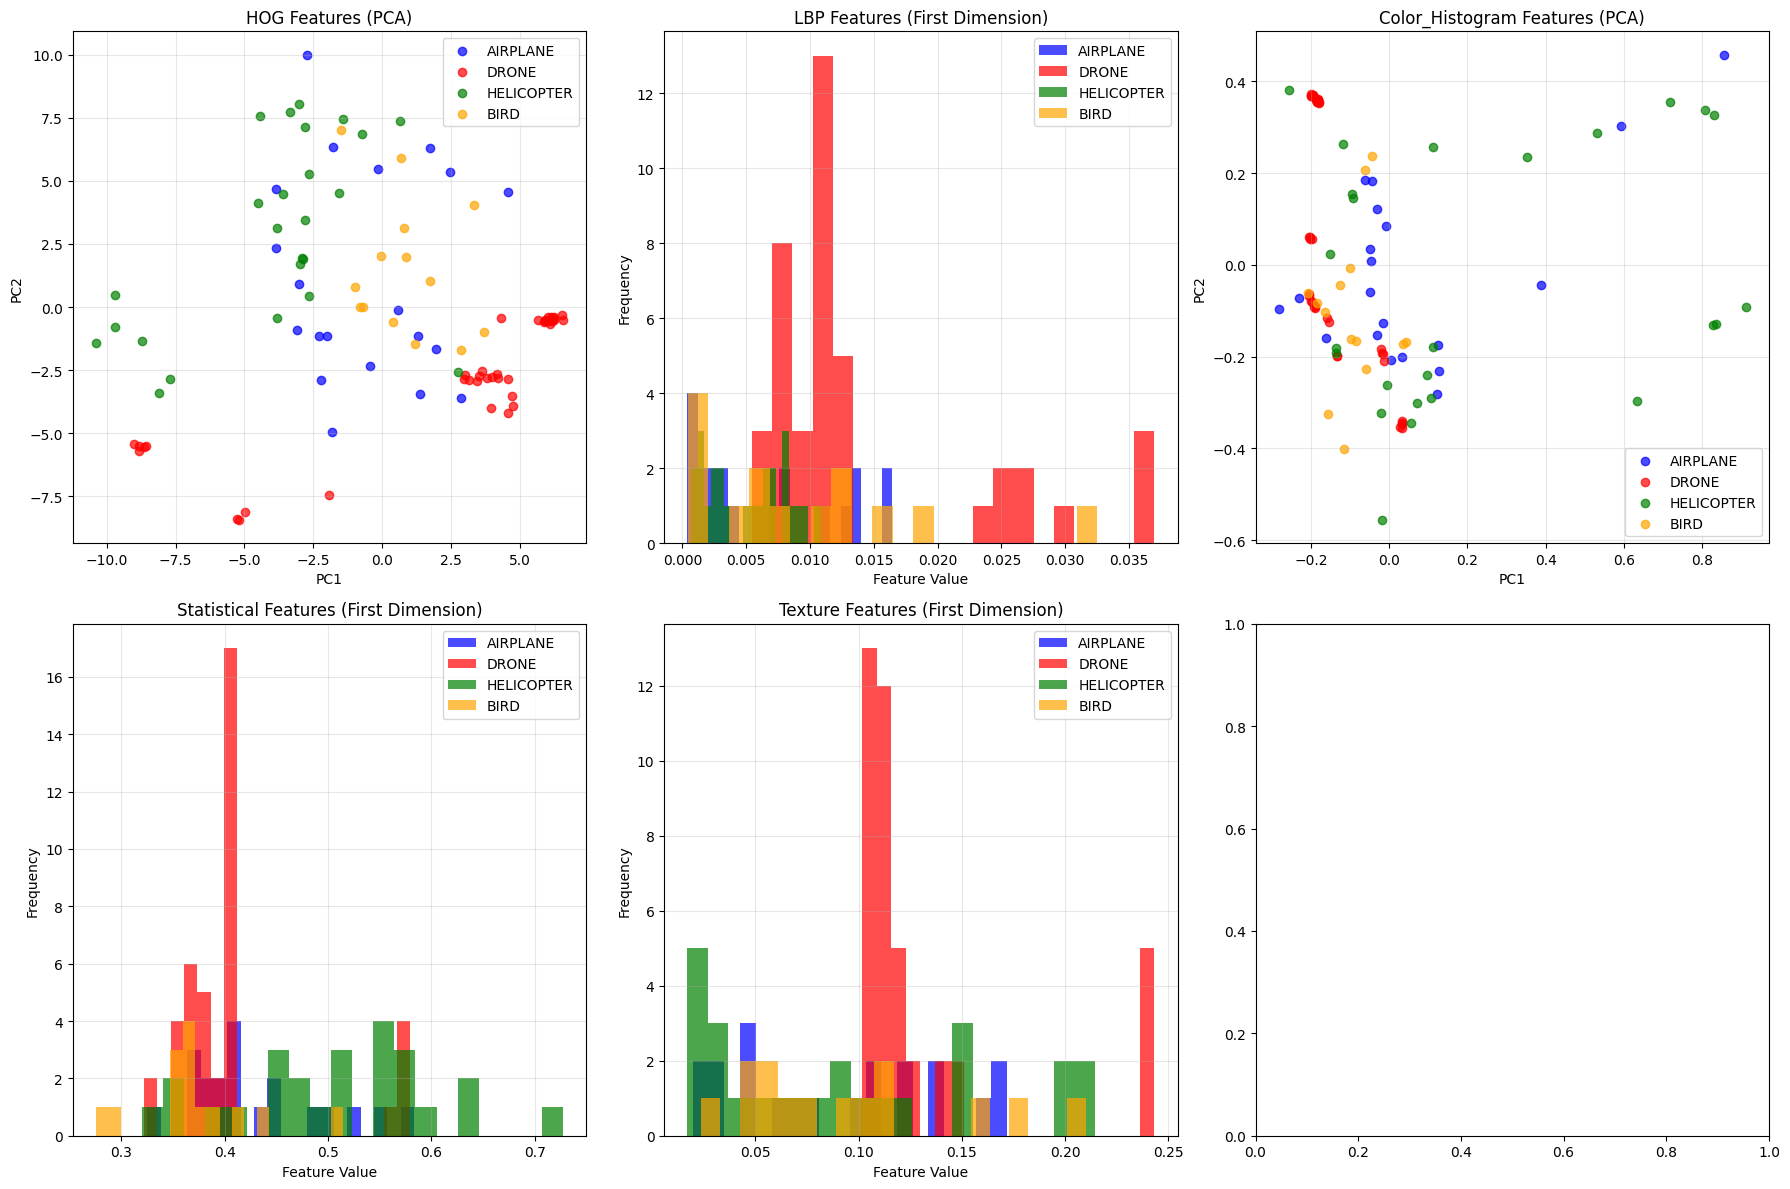

In [106]:
# Extract traditional features
traditional_features = extract_traditional_features(X_train_cls, y_train_cls)

# Model Training

In [107]:
def create_classification_model(input_shape=(224, 224, 3), num_classes=4):
    '''
    Create a classification model
    '''
    model = Sequential([
        InputLayer(input_shape=input_shape),

        # Feature extraction
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Global average pooling
        tf.keras.layers.GlobalAveragePooling2D(),

        # Dense layers
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    return model

In [108]:
def train_classification_model(X_train, y_train, X_val=None, y_val=None):
    '''
    Train classification model
    '''
    print("="*60)
    print("TRAINING CLASSIFICATION MODEL")
    print("="*60)

    model = create_classification_model()

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary
    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
        ModelCheckpoint('best_classification_model.h5', save_best_only=True, monitor='val_loss')
    ]

    # Prepare validation data
    if X_val is None or y_val is None:
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
        )

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Classes distribution in training: {Counter(y_train)}")

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

In [109]:
def plot_training_history(history, title="Training History"):
    '''
    Plot training history
    '''
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot accuracy (if available)
    if 'accuracy' in history.history:
        axes[1].plot(history.history['accuracy'], label='Training Accuracy')
        axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[1].set_title('Model Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid(True)
    else:
        # Plot MAE for detection model
        if 'mae' in history.history:
            axes[1].plot(history.history['mae'], label='Training MAE')
            axes[1].plot(history.history['val_mae'], label='Validation MAE')
            axes[1].set_title('Model MAE')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('MAE')
            axes[1].legend()
            axes[1].grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [110]:
def evaluate_classification_model(model, X_test, y_test):
    '''
    Evaluate classification model
    '''
    print("="*60)
    print("EVALUATING CLASSIFICATION MODEL")
    print("="*60)

    # Make predictions
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)

    # Calculate accuracy
    accuracy = np.mean(predicted_classes == y_test)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Classification report
    from sklearn.metrics import classification_report, confusion_matrix

    print("\nClassification Report:")
    print(classification_report(y_test, predicted_classes, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, predicted_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return accuracy

## Train classification model on original data


Starting classification model training on original data...
TRAINING CLASSIFICATION MODEL


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,276 (2.50 MB)

 Trainable params: 653,316 (2.49 MB)

 Non-trainable params: 960 (3.75 KB)

Training samples: 2000
Validation samples: 400
Classes distribution in training: Counter({np.int64(1): 802, np.int64(2): 417, np.int64(0): 416, np.int64(3): 365})
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5941 - loss: 1.0031

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.5950 - loss: 1.0006 - val_accuracy: 0.2125 - val_loss: 2.6391 - learning_rate: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7315 - loss: 0.6127 - val_accuracy: 0.3275 - val_loss: 3.2763 - learning_rate: 0.0010
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7886 - loss: 0.5066 - val_accuracy: 0.3125 - val_loss: 4.3533 - learning_rate: 0.0010
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8041 - loss: 0.4634 - val_accuracy: 0.2625 - val_loss: 4.1991 - learning_rate: 0.0010
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8459 - loss: 0.3628 - val_accuracy: 0.3225 - val_loss: 3.9463 - learning_rate: 0.0010
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8395 - loss: 0.3571 - val_accuracy: 0.2250 - val_loss: 4.7829 - learning_rate: 0.0010
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8793 - loss: 0.2928 - val_accuracy: 0.

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8984 - loss: 0.2460 - val_accuracy: 0.5525 - val_loss: 1.1304 - learning_rate: 5.0000e-04
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9153 - loss: 0.2208 - val_accuracy: 0.3900 - val_loss: 2.9687 - learning_rate: 5.0000e-04
Epoch 11/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8833 - loss: 0.2575

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8838 - loss: 0.2568 - val_accuracy: 0.6975 - val_loss: 0.7245 - learning_rate: 5.0000e-04
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9085 - loss: 0.2126

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9085 - loss: 0.2125 - val_accuracy: 0.6875 - val_loss: 0.6545 - learning_rate: 5.0000e-04
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9139 - loss: 0.1949 - val_accuracy: 0.4100 - val_loss: 1.9429 - learning_rate: 5.0000e-04
Epoch 14/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9111 - loss: 0.1989

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9112 - loss: 0.1990 - val_accuracy: 0.8350 - val_loss: 0.3756 - learning_rate: 5.0000e-04
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9253 - loss: 0.2023 - val_accuracy: 0.7525 - val_loss: 0.6773 - learning_rate: 5.0000e-04
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9104 - loss: 0.1955

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9104 - loss: 0.1956 - val_accuracy: 0.8750 - val_loss: 0.3333 - learning_rate: 5.0000e-04
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9290 - loss: 0.1679 - val_accuracy: 0.7800 - val_loss: 0.7679 - learning_rate: 5.0000e-04
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9254 - loss: 0.1869

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9254 - loss: 0.1868 - val_accuracy: 0.9050 - val_loss: 0.2673 - learning_rate: 5.0000e-04
Epoch 19/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9136 - loss: 0.1872 - val_accuracy: 0.8500 - val_loss: 0.3052 - learning_rate: 5.0000e-04
Epoch 20/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9455 - loss: 0.1374

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9453 - loss: 0.1377 - val_accuracy: 0.8850 - val_loss: 0.2350 - learning_rate: 5.0000e-04


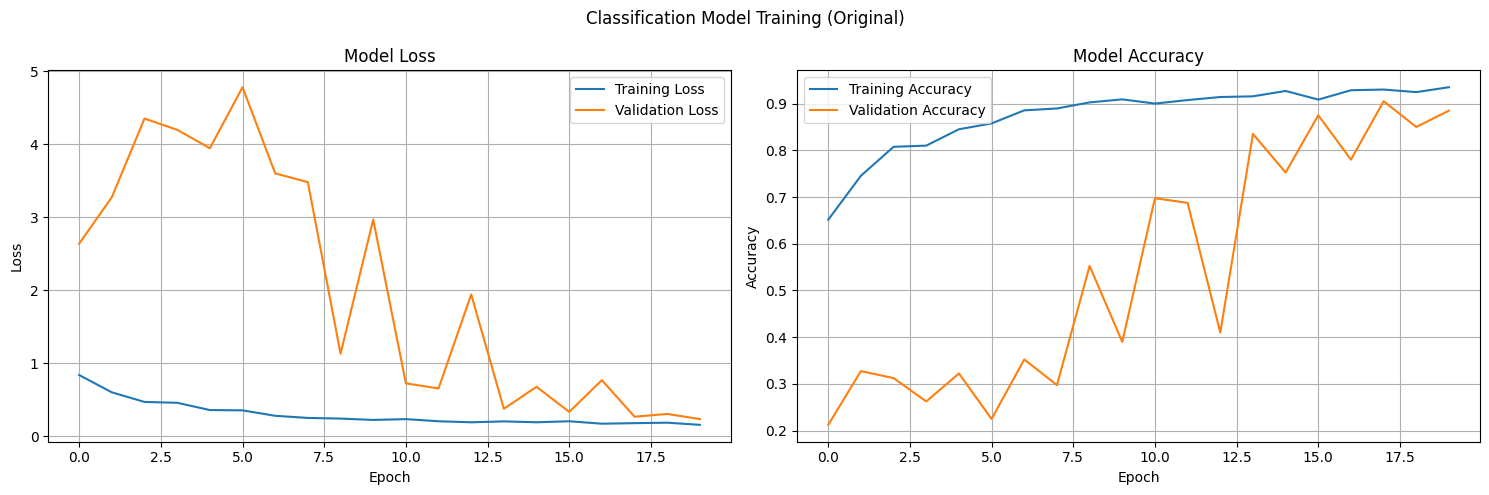

EVALUATING CLASSIFICATION MODEL
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
Test Accuracy: 0.8700

Classification Report:
              precision    recall  f1-score   support

    AIRPLANE       0.71      0.89      0.79        90
       DRONE       0.99      1.00      0.99       165
  HELICOPTER       0.80      0.79      0.79        70
        BIRD       0.92      0.64      0.76        75

    accuracy                           0.87       400
   macro avg       0.86      0.83      0.83       400
weighted avg       0.88      0.87      0.87       400



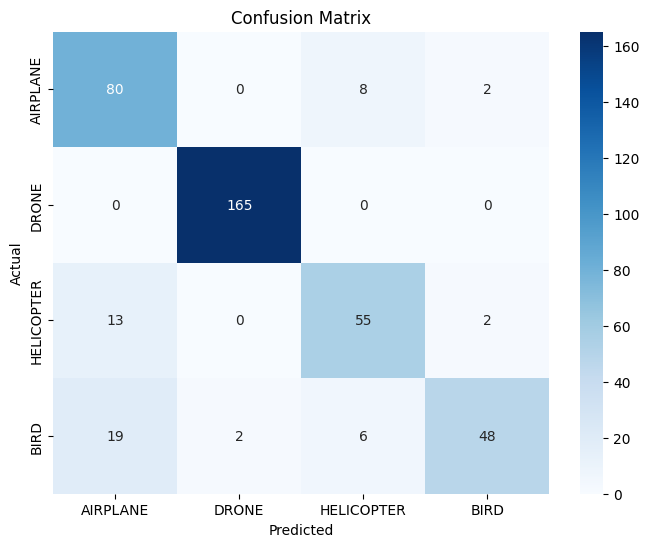

Final Classification Test Accuracy (Original): 0.8700


In [111]:
# Train classification model on original data
def train_classification_model_original(X_train, y_train, X_val=None, y_val=None):
    '''
    Train classification model on original data
    '''
    print("\nStarting classification model training on original data...")
    try:
        cls_model, cls_history = train_classification_model(
            X_train_cls, y_train_cls, X_val_cls, y_val_cls
        )

        # Plot training history
        plot_training_history(cls_history, "Classification Model Training (Original)")

        # Evaluate on test set
        if X_test_cls is not None and len(X_test_cls) > 0:
            accuracy_original = evaluate_classification_model(cls_model, X_test_cls, y_test_cls)
            print(f"Final Classification Test Accuracy (Original): {accuracy_original:.4f}")
        return cls_model, cls_history
    except Exception as e:
        print(f"Error during classification training: {e}")
        import traceback
        traceback.print_exc()
        cls_model = None

cls_model, cls_history = train_classification_model_original(X_train_cls, y_train_cls, X_val_cls, y_val_cls)

## Train Classification Model Denoised


Starting classification model training on denoised data...
TRAINING CLASSIFICATION MODEL


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,276 (2.50 MB)

 Trainable params: 653,316 (2.49 MB)

 Non-trainable params: 960 (3.75 KB)

Training samples: 2000
Validation samples: 400
Classes distribution in training: Counter({np.int64(1): 802, np.int64(2): 417, np.int64(0): 416, np.int64(3): 365})
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5996 - loss: 0.9775

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.6005 - loss: 0.9753 - val_accuracy: 0.2450 - val_loss: 2.3743 - learning_rate: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7237 - loss: 0.6418 - val_accuracy: 0.2375 - val_loss: 3.6223 - learning_rate: 0.0010
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7640 - loss: 0.5764 - val_accuracy: 0.2475 - val_loss: 3.7284 - learning_rate: 0.0010
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.7898 - loss: 0.5133 - val_accuracy: 0.2325 - val_loss: 4.3669 - learning_rate: 0.0010
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8011 - loss: 0.5051 - val_accuracy: 0.3725 - val_loss: 4.1651 - learning_rate: 0.0010
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8286 - loss: 0.4007 - val_accuracy: 0.3325 - val_loss: 3.1644 - learning_rate: 0.0010
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8441 - loss: 0.3484 - val_accuracy: 0.

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8691 - loss: 0.3104 - val_accuracy: 0.3250 - val_loss: 2.3544 - learning_rate: 5.0000e-04
Epoch 9/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8933 - loss: 0.2826

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8935 - loss: 0.2822 - val_accuracy: 0.6525 - val_loss: 0.7708 - learning_rate: 5.0000e-04
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9124 - loss: 0.2372

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9122 - loss: 0.2375 - val_accuracy: 0.7525 - val_loss: 0.7346 - learning_rate: 5.0000e-04
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8854 - loss: 0.2707

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8855 - loss: 0.2706 - val_accuracy: 0.8700 - val_loss: 0.2929 - learning_rate: 5.0000e-04
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8933 - loss: 0.2629 - val_accuracy: 0.8625 - val_loss: 0.4077 - learning_rate: 5.0000e-04
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8959 - loss: 0.2519 - val_accuracy: 0.3225 - val_loss: 5.8920 - learning_rate: 5.0000e-04
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9024 - loss: 0.2458 - val_accuracy: 0.5750 - val_loss: 1.8990 - learning_rate: 5.0000e-04
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9038 - loss: 0.2318 - val_accuracy: 0.6625 - val_loss: 1.8699 - learning_rate: 5.0000e-04
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9006 - loss: 0.2387 - val_accuracy: 0.8250 - val_loss: 0.5843 - learning_rate: 5.0000e-04
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9045 - los

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9048 - loss: 0.2328 - val_accuracy: 0.9175 - val_loss: 0.1803 - learning_rate: 2.5000e-04
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9250 - loss: 0.1684 - val_accuracy: 0.9300 - val_loss: 0.2029 - learning_rate: 2.5000e-04
Epoch 19/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9264 - loss: 0.1706 - val_accuracy: 0.9075 - val_loss: 0.2017 - learning_rate: 2.5000e-04
Epoch 20/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9123 - loss: 0.2140 - val_accuracy: 0.7600 - val_loss: 0.5908 - learning_rate: 2.5000e-04


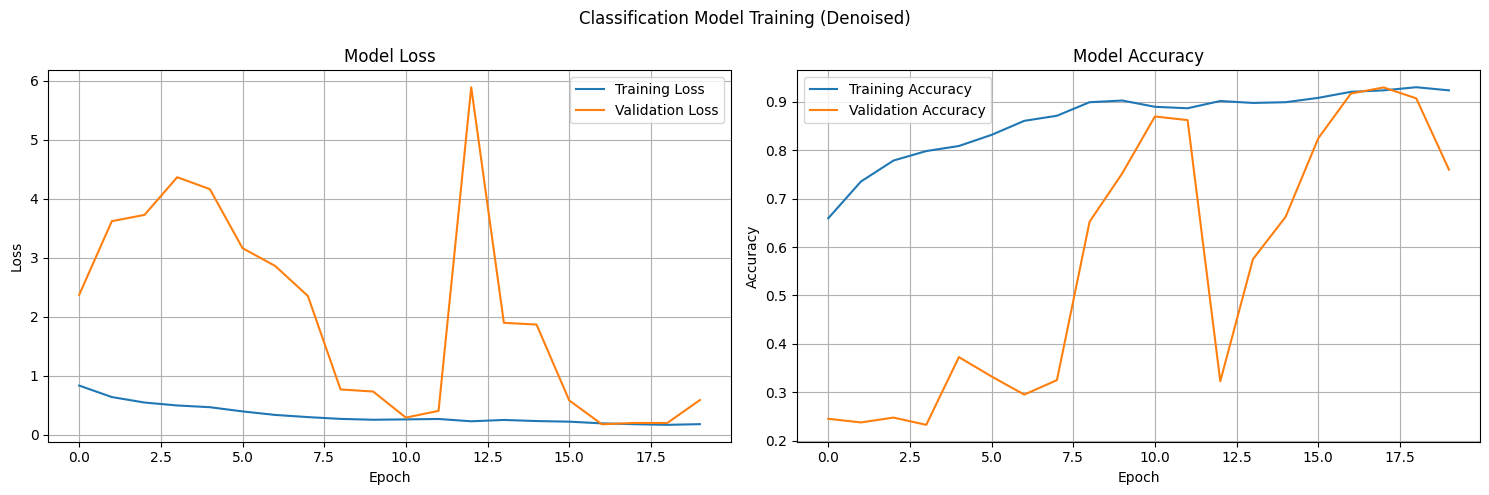

EVALUATING CLASSIFICATION MODEL
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step
Test Accuracy: 0.9300

Classification Report:
              precision    recall  f1-score   support

    AIRPLANE       0.85      0.88      0.86        90
       DRONE       0.99      1.00      0.99       165
  HELICOPTER       0.85      0.96      0.90        70
        BIRD       1.00      0.81      0.90        75

    accuracy                           0.93       400
   macro avg       0.92      0.91      0.91       400
weighted avg       0.93      0.93      0.93       400



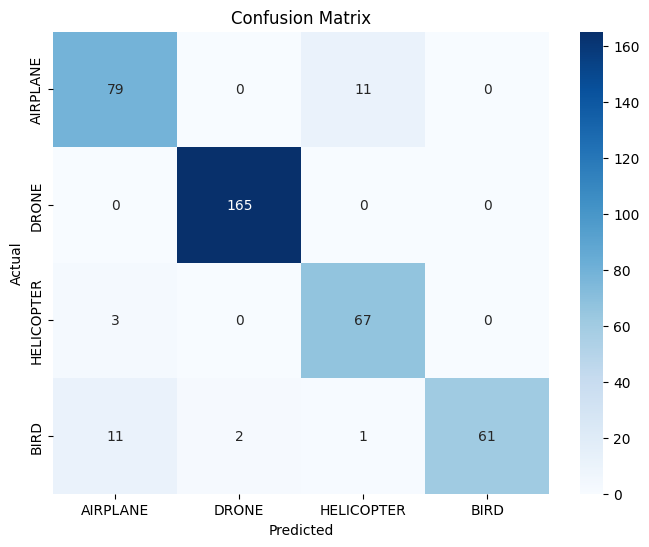

Final Classification Test Accuracy (Denoised): 0.9300


In [112]:
# Train classification model on denoised data
def train_classification_model_denoised(X_train_denoised, y_train):
    '''
    Train classification model on denoised data
    '''
    print("\nStarting classification model training on denoised data...")
    try:
        cls_model_denoised, cls_history_denoised = train_classification_model(
            X_train_denoised, y_train_cls, X_val_cls, y_val_cls
        )

        # Plot training history
        plot_training_history(cls_history_denoised, "Classification Model Training (Denoised)")

        # Evaluate on test set
        if X_test_cls is not None and len(X_test_cls) > 0:
            # Apply denoising to test set
            X_test_denoised = np.zeros_like(X_test_cls)
            for i in range(len(X_test_cls)):
                img_uint8 = (X_test_cls[i] * 255).astype(np.uint8)
                blurred = cv2.GaussianBlur(img_uint8, (3, 3), 0)
                X_test_denoised[i] = blurred / 255.0

            accuracy_denoised = evaluate_classification_model(cls_model_denoised, X_test_denoised, y_test_cls)
            print(f"Final Classification Test Accuracy (Denoised): {accuracy_denoised:.4f}")

            return cls_model_denoised, cls_history_denoised
    except Exception as e:
        print(f"Error during denoised classification training: {e}")
        import traceback
        traceback.print_exc()
        cls_model_denoised = None

cls_model_denoised, cls_history_denoised = train_classification_model_denoised(X_train_denoised, y_train_cls)

## Train Detection Model

In [113]:
# Model creation functions (keeping original functions)
def create_detection_model(input_shape=(224, 224, 3), num_classes=4, max_boxes=10):
    '''
    Create a simplified detection model that predicts class + bounding box for multiple objects
    '''
    inputs = Input(shape=input_shape)

    # Feature extraction backbone
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Dense layers
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer for multiple object detection
    # Output shape: (batch_size, max_boxes * 5) where each box has [class, x, y, w, h]
    x = Dense(max_boxes * 5, activation='linear')(x)

    # Reshape to (batch_size, max_boxes, 5)
    outputs = Reshape((max_boxes, 5), name='detection_output')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [114]:
def visualize_detection_predictions(X_test, Y_true, Y_pred, num_samples=6):
    '''
    Visualize detection predictions
    '''
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Detection Model Predictions vs Ground Truth', fontsize=16, fontweight='bold')
    axes = axes.flatten()

    # Select random samples
    indices = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)

    for i, idx in enumerate(indices):
        if i >= num_samples:
            break

        img = X_test[idx]
        true_boxes = Y_true[idx]
        pred_boxes = Y_pred[idx]

        # Display image
        axes[i].imshow(img)
        axes[i].set_title(f'Image {idx}')
        axes[i].axis('off')

        img_height, img_width = img.shape[:2]

        # Draw ground truth boxes in blue
        for j, box in enumerate(true_boxes):
            if np.sum(np.abs(box)) > 0:  # Valid box
                class_id, x_center, y_center, width, height = box

                # Convert to pixel coordinates
                x_center *= img_width
                y_center *= img_height
                width *= img_width
                height *= img_height

                # Calculate top-left corner
                x1 = x_center - width / 2
                y1 = y_center - height / 2

                # Draw ground truth rectangle (blue)
                rect = Rectangle((x1, y1), width, height,
                               linewidth=2, edgecolor='blue', facecolor='none')
                axes[i].add_patch(rect)

                # Add class label
                if int(class_id) < len(class_names):
                    axes[i].text(x1, y1-5, f'GT: {class_names[int(class_id)]}',
                               color='blue', fontsize=8, fontweight='bold',
                               bbox=dict(facecolor='white', alpha=0.8, pad=1))

        # Draw predicted boxes in red
        for j, box in enumerate(pred_boxes):
            if np.sum(np.abs(box)) > 0.1:  # Valid prediction (threshold)
                class_id, x_center, y_center, width, height = box

                # Convert to pixel coordinates
                x_center *= img_width
                y_center *= img_height
                width *= img_width
                height *= img_height

                # Calculate top-left corner
                x1 = x_center - width / 2
                y1 = y_center - height / 2

                # Draw prediction rectangle (red)
                rect = Rectangle((x1, y1), width, height,
                               linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
                axes[i].add_patch(rect)

                # Add class label
                pred_class = int(np.round(class_id))
                if 0 <= pred_class < len(class_names):
                    axes[i].text(x1, y1+height+5, f'Pred: {class_names[pred_class]}',
                               color='red', fontsize=8, fontweight='bold',
                               bbox=dict(facecolor='white', alpha=0.8, pad=1))

    plt.tight_layout()
    plt.show()

In [115]:
def evaluate_detection_model(model, X_test, Y_test):
    '''
    Evaluate detection model
    '''
    print("="*60)
    print("EVALUATING DETECTION MODEL")
    print("="*60)

    # Make predictions
    predictions = model.predict(X_test)

    # Calculate various metrics
    mae = mae_metric(Y_test, predictions)
    mse = mse_loss(Y_test, predictions)

    print(f"Test MAE: {tf.reduce_mean(mae):.4f}")
    print(f"Test MSE: {tf.reduce_mean(mse):.4f}")

    # Visualize some predictions
    visualize_detection_predictions(X_test, Y_test, predictions, num_samples=6)

    return tf.reduce_mean(mae).numpy()

In [116]:
def detection_loss(y_true, y_pred):
    '''
    Detection loss using MSE
    '''
    # Calculate MSE loss between predictions and ground truth
    loss = mse_loss(y_true, y_pred)

    # Create mask for valid boxes
    valid_mask = tf.reduce_sum(tf.abs(y_true), axis=-1) > 0
    valid_mask_float = tf.cast(valid_mask, tf.float32)

    # Apply mask and return mean loss
    masked_loss = loss * valid_mask_float

    # Calculate mean only over valid samples
    num_valid = tf.reduce_sum(valid_mask_float, axis=-1)
    num_valid = tf.maximum(num_valid, 1.0)

    sample_loss = tf.reduce_sum(masked_loss, axis=-1) / num_valid

    return tf.reduce_mean(sample_loss)

In [117]:
def train_detection_model(X_train, Y_train, X_val=None, Y_val=None):
    '''
    Train detection model
    '''
    print("="*60)
    print("TRAINING DETECTION MODEL")
    print("="*60)

    model = create_detection_model()

    # Compile model with simplified loss
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
        loss=detection_loss,
        metrics=['mae']
    )

    # Print model summary
    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-8),
        ModelCheckpoint('best_detection_model.h5', save_best_only=True, monitor='val_loss')
    ]

    # Prepare validation data
    if X_val is None or Y_val is None:
        X_train, X_val, Y_train, Y_val = train_test_split(
            X_train, Y_train, test_size=0.2, random_state=42
        )

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Input shape: {X_train.shape}")
    print(f"Output shape: {Y_train.shape}")

    # Train model
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=EPOCHS,  # Reduced epochs for initial training
        batch_size=SMALL_BATCH_SIZE,   # Smaller batch size
        callbacks=callbacks,
        verbose=1
    )

    return model, history


Starting detection model training...
TRAINING DETECTION MODEL


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 50)             │        12,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ detection_output (Reshape)      │ (None, 10, 5)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 666,098 (2.54 MB)

 Trainable params: 665,138 (2.54 MB)

 Non-trainable params: 960 (3.75 KB)

Training samples: 2000
Validation samples: 400
Input shape: (2000, 224, 224, 3)
Output shape: (2000, 10, 5)
Epoch 1/20
247/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1381 - mae: 0.2389

250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.1371 - mae: 0.2377 - val_loss: 0.0912 - val_mae: 0.1887 - learning_rate: 1.0000e-04
Epoch 2/20
247/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0342 - mae: 0.1031

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0342 - mae: 0.1030 - val_loss: 0.0507 - val_mae: 0.1012 - learning_rate: 1.0000e-04
Epoch 3/20
246/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0272 - mae: 0.0858

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0272 - mae: 0.0857 - val_loss: 0.0205 - val_mae: 0.0420 - learning_rate: 1.0000e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0246 - mae: 0.0770

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0246 - mae: 0.0770 - val_loss: 0.0169 - val_mae: 0.0372 - learning_rate: 1.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0224 - mae: 0.0718

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0224 - mae: 0.0718 - val_loss: 0.0162 - val_mae: 0.0353 - learning_rate: 1.0000e-04
Epoch 6/20
246/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0191 - mae: 0.0656

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0191 - mae: 0.0656 - val_loss: 0.0148 - val_mae: 0.0323 - learning_rate: 1.0000e-04
Epoch 7/20
247/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0199 - mae: 0.0632

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0199 - mae: 0.0632 - val_loss: 0.0144 - val_mae: 0.0322 - learning_rate: 1.0000e-04
Epoch 8/20
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0196 - mae: 0.0605

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0196 - mae: 0.0605 - val_loss: 0.0133 - val_mae: 0.0288 - learning_rate: 1.0000e-04
Epoch 9/20
246/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0178 - mae: 0.0574

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0178 - mae: 0.0574 - val_loss: 0.0130 - val_mae: 0.0280 - learning_rate: 1.0000e-04
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0172 - mae: 0.0543 - val_loss: 0.0142 - val_mae: 0.0313 - learning_rate: 1.0000e-04
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0164 - mae: 0.0519 - val_loss: 0.0131 - val_mae: 0.0286 - learning_rate: 1.0000e-04
Epoch 12/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0158 - mae: 0.0497 - val_loss: 0.0169 - val_mae: 0.0329 - learning_rate: 1.0000e-04
Epoch 13/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0158 - mae: 0.0485 - val_loss: 0.0131 - val_mae: 0.0267 - learning_rate: 1.0000e-04
Epoch 14/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0164 - mae: 0.0473

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0164 - mae: 0.0473 - val_loss: 0.0125 - val_mae: 0.0257 - learning_rate: 1.0000e-04
Epoch 15/20
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0169 - mae: 0.0461

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0168 - mae: 0.0461 - val_loss: 0.0118 - val_mae: 0.0248 - learning_rate: 1.0000e-04
Epoch 16/20
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0146 - mae: 0.0436

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0146 - mae: 0.0436 - val_loss: 0.0107 - val_mae: 0.0224 - learning_rate: 1.0000e-04
Epoch 17/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0141 - mae: 0.0426 - val_loss: 0.0129 - val_mae: 0.0260 - learning_rate: 1.0000e-04
Epoch 18/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0137 - mae: 0.0405 - val_loss: 0.0136 - val_mae: 0.0255 - learning_rate: 1.0000e-04
Epoch 19/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0141 - mae: 0.0401 - val_loss: 0.0116 - val_mae: 0.0235 - learning_rate: 1.0000e-04
Epoch 20/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0140 - mae: 0.0393 - val_loss: 0.0166 - val_mae: 0.0277 - learning_rate: 1.0000e-04


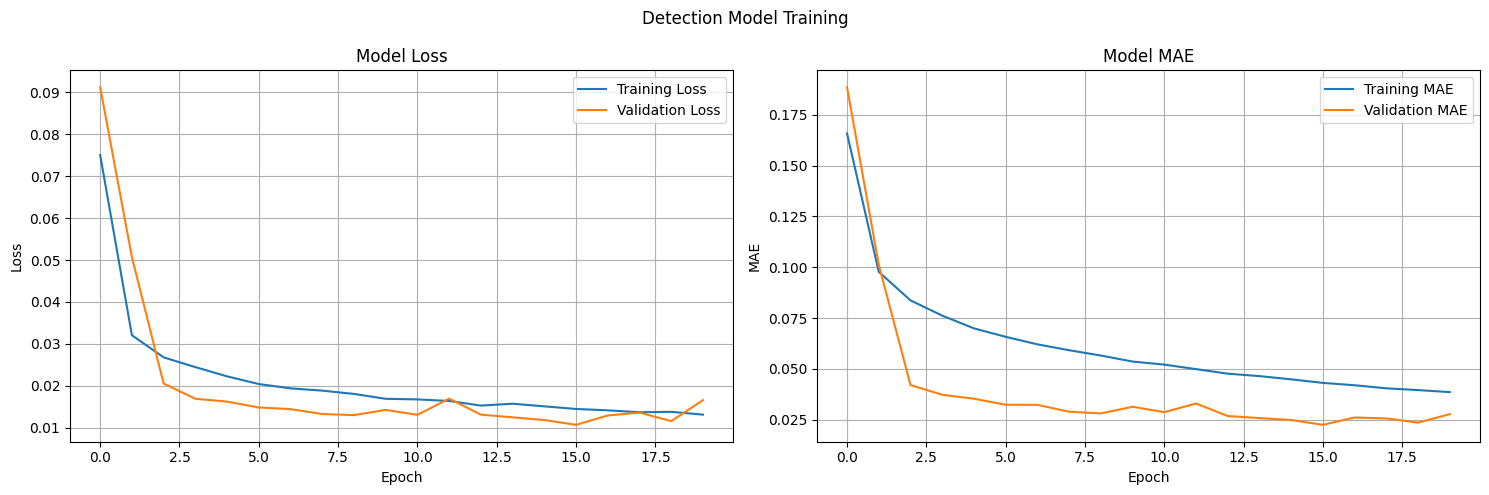

EVALUATING DETECTION MODEL
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step
Test MAE: 0.0219
Test MSE: 0.0108


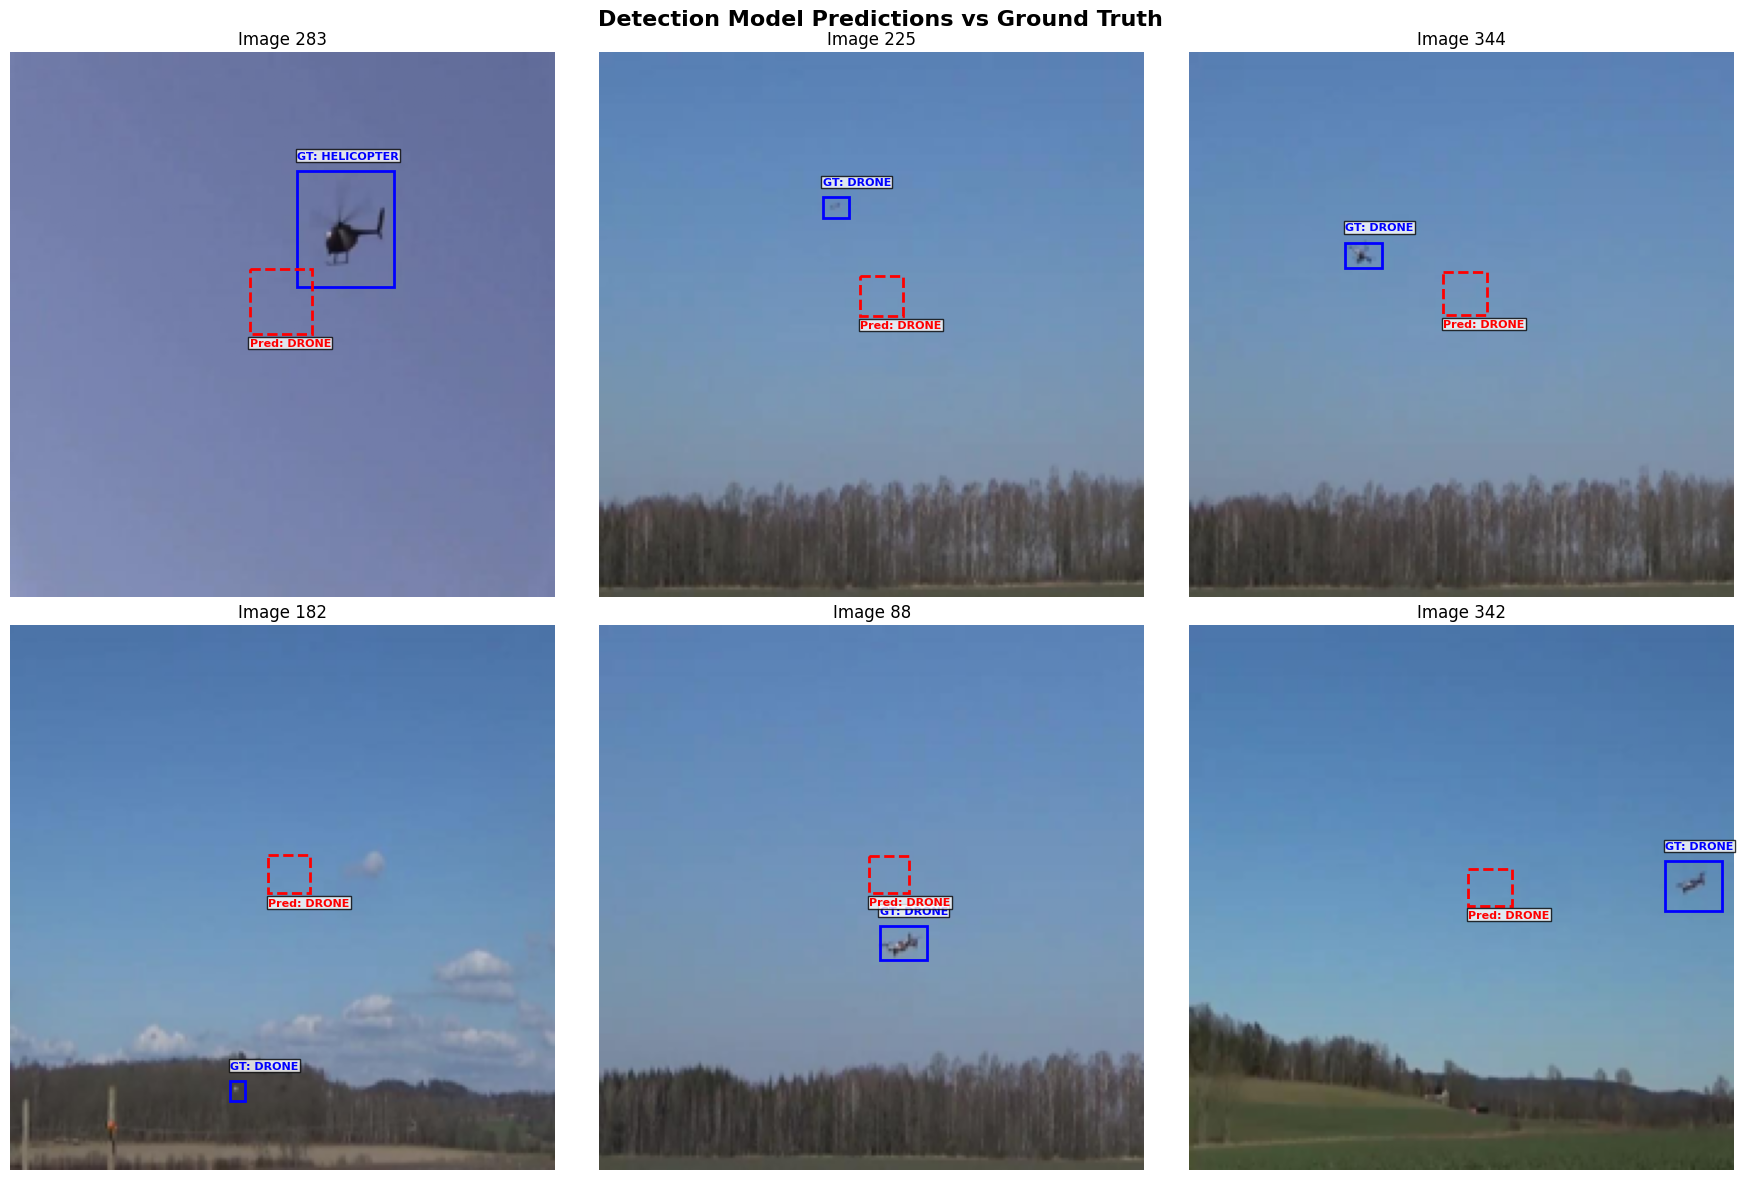

Final Detection Test MAE: 0.0219


In [118]:
# Train and evaluate detection model (simplified)
def train_and_evaluate_detection_model(X_train, Y_train, X_val=None, Y_val=None):
    '''
    Train detection model (simplified)
    '''
    print("\nStarting detection model training...")
    try:
        det_model, det_history = train_detection_model(
            X_train, Y_train, X_val, Y_val
        )

        # Plot training history
        plot_training_history(det_history, "Detection Model Training")

        # Evaluate on test set
        if X_test is not None and len(X_test) > 0:
            mae = evaluate_detection_model(det_model, X_test, Y_test)
            print(f"Final Detection Test MAE: {mae:.4f}")

        return det_model, det_history
    except Exception as e:
        print(f"Error during detection training: {e}")
        import traceback
        traceback.print_exc()
        det_model = None

det_model, det_history = train_and_evaluate_detection_model(X_train, Y_train, X_val, Y_val)

In [120]:
# Main function
def main():
    '''
    Training pipeline
    '''

    # Return comprehensive results
    results = {
        'classification_model': cls_model if 'cls_model' in locals() else None,
        'classification_model_denoised': cls_model_denoised if 'cls_model_denoised' in locals() else None,
        'detection_model': det_model if 'det_model' in locals() else None,
        'eda_results': eda_results,
        'traditional_features': traditional_features,
        'denoising_techniques': denoising_techniques,
        'train_data': (X_train, Y_train),
        'val_data': (X_val, Y_val) if X_val is not None else None,
        'test_data': (X_test, Y_test) if X_test is not None else None,
        'classification_data': (X_train_cls, y_train_cls),
        'denoised_data': X_train_denoised
    }

    return results


# Additional utility functions for advanced analysis
def analyze_augmentation_effects(X, y_labels, augmentation_strategies):
    '''
    Analyze the effects of different augmentation strategies
    '''
    print("="*60)
    print("AUGMENTATION EFFECTS ANALYSIS")
    print("="*60)

    # This function would implement various augmentation techniques
    # and analyze their effects on the dataset distribution

    augmentation_results = {}

    # Example augmentations (simplified for demonstration)
    strategies = {
        'rotation': lambda img: np.rot90(img, k=1),
        'flip_horizontal': lambda img: np.fliplr(img),
        'brightness_increase': lambda img: np.clip(img * 1.2, 0, 1),
        'brightness_decrease': lambda img: np.clip(img * 0.8, 0, 1)
    }

    # Analyze each strategy
    for strategy_name, strategy_func in strategies.items():
        print(f"Analyzing {strategy_name}...")

        # Apply augmentation to a subset
        subset_size = min(50, len(X))
        subset_indices = np.random.choice(len(X), subset_size, replace=False)

        original_stats = []
        augmented_stats = []

        for idx in subset_indices:
            img = X[idx]
            aug_img = strategy_func(img)

            # Calculate statistics
            hist_orig, _ = np.histogram(img.flatten(), bins=256, density=True)
            hist_orig = hist_orig[hist_orig > 0]
            entropy_orig = -np.sum(hist_orig * np.log2(hist_orig + 1e-10))

            original_stats.append({
                'brightness': np.mean(img),
                'contrast': np.std(img),
                'entropy': entropy_orig
            })

            hist_aug, _ = np.histogram(aug_img.flatten(), bins=256, density=True)
            hist_aug = hist_aug[hist_aug > 0]
            entropy_aug = -np.sum(hist_aug * np.log2(hist_aug + 1e-10))

            augmented_stats.append({
                'brightness': np.mean(aug_img),
                'contrast': np.std(aug_img),
                'entropy': entropy_aug
            })

        augmentation_results[strategy_name] = {
            'original': original_stats,
            'augmented': augmented_stats
        }

    return augmentation_results

def analyze_model_complexity(X_train, y_train):
    '''
    Analyze optimal model complexity through various experiments
    '''
    print("="*60)
    print("MODEL COMPLEXITY ANALYSIS")
    print("="*60)

    # This function would test different model architectures
    # and analyze their performance vs complexity trade-offs

    complexity_results = {
        'layer_depths': [],
        'filter_counts': [],
        'performance_metrics': []
    }

    # Example: Test different layer depths
    layer_configs = [2, 4, 6, 8]

    for depth in layer_configs:
        print(f"Testing model with {depth} convolutional layers...")

        # Create a simple model for testing
        model = Sequential()
        model.add(InputLayer(input_shape=X_train.shape[1:]))

        for i in range(depth):
            filters = 32 * (2 ** min(i, 3))  # Increase filters: 32, 64, 128, 256
            model.add(Conv2D(filters, (3, 3), activation='relu', padding='same'))
            model.add(BatchNormalization())
            if i < depth - 1:  # Don't pool after last conv layer
                model.add(MaxPooling2D((2, 2)))

        model.add(tf.keras.layers.GlobalAveragePooling2D())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(NUM_CLASSES, activation='softmax'))

        # Count parameters
        total_params = model.count_params()

        complexity_results['layer_depths'].append(depth)
        complexity_results['filter_counts'].append(total_params)

        print(f"Model with {depth} layers has {total_params:,} parameters")

    return complexity_results

# Execute enhanced training
if __name__ == "__main__":
    # Run the enhanced version with comprehensive EDA
    results = main()

    # Optionally, you can also run additional analyses
    if results is not None:
        print("\nPerforming additional analyses...")

        # Augmentation analysis
        X_train_cls = results['classification_data'][0]
        y_train_cls = results['classification_data'][1]

        # Example usage of additional analysis functions
        aug_results = analyze_augmentation_effects(X_train_cls[:100], y_train_cls[:100], {})
        complexity_results = analyze_model_complexity(X_train_cls[:100], y_train_cls[:100])
        print("\nAugmentation Analysis Results:")
        print(aug_results)
        print("\nModel Complexity Analysis Results:")
        print(complexity_results)
        print("All analyses completed successfully!")


Performing additional analyses...
AUGMENTATION EFFECTS ANALYSIS
Analyzing rotation...
Analyzing flip_horizontal...
Analyzing brightness_increase...
Analyzing brightness_decrease...
MODEL COMPLEXITY ANALYSIS
Testing model with 2 convolutional layers...
Model with 2 layers has 28,612 parameters
Testing model with 4 convolutional layers...
Model with 4 layers has 423,748 parameters
Testing model with 6 convolutional layers...
Model with 6 layers has 1,605,956 parameters
Testing model with 8 convolutional layers...
Model with 8 layers has 2,788,164 parameters

Augmentation Analysis Results:
{'rotation': {'original': [{'brightness': np.float32(0.4904039), 'contrast': np.float32(0.1756808), 'entropy': np.float64(-494.91612816977664)}, {'brightness': np.float32(0.53815454), 'contrast': np.float32(0.15905678), 'entropy': np.float64(-517.2361940418131)}, {'brightness': np.float32(0.49328843), 'contrast': np.float32(0.17696209), 'entropy': np.float64(-428.21330866164385)}, {'brightness': np.flo